In [273]:
require(ggplot2) # for data visualization
require(stringr) #extracting string patterns
require(Matrix) # matrix transformations
require(glmnet) # ridge, lasso & elastinet
require(xgboost) # gbm
require(randomForest)
require(Metrics) # rmse
require(caret) # one hot encoding
require(scales) # plotting $$
require(e1071) # skewness
require(corrplot) # correlation plot
require(GGally) # Scatterplot Matrix
require(dplyr) # load this in last so plyr doens't overlap it

In [8]:
# Set working directory
setwd("C:/Users/User/Desktop/Kaggle/House Prices")

In [10]:
# Read the train and test files
train <- read.csv('train.csv', stringsAsFactors = FALSE)
test <- read.csv('test.csv', stringsAsFactors = FALSE)


# combine the datasets
df.combined <- rbind(within(train, rm('Id','SalePrice')), within(test, rm('Id')))
dim(df.combined)

[1] 2919   79

In [11]:
# Finding out missing values
na.cols <- which(colSums(is.na(df.combined)) > 0)
sort(colSums(sapply(df.combined[na.cols], is.na)), decreasing = TRUE)

PoolQC  MiscFeature        Alley        Fence  FireplaceQu  LotFrontage 
        2909         2814         2721         2348         1420          486 
 GarageYrBlt GarageFinish   GarageQual   GarageCond   GarageType     BsmtCond 
         159          159          159          159          157           82 
BsmtExposure     BsmtQual BsmtFinType2 BsmtFinType1   MasVnrType   MasVnrArea 
          82           81           80           79           24           23 
    MSZoning    Utilities BsmtFullBath BsmtHalfBath   Functional  Exterior1st 
           4            2            2            2            2            1 
 Exterior2nd   BsmtFinSF1   BsmtFinSF2    BsmtUnfSF  TotalBsmtSF   Electrical 
           1            1            1            1            1            1 
 KitchenQual   GarageCars   GarageArea     SaleType 
           1            1            1            1

In [12]:
cat('There are', length(na.cols), 'columns with missing values')

There are 34 columns with missing values

In [22]:
# helper function for plotting categoric data for easier data visualization
plot.categoric <- function(cols, df){
  for (col in cols) {
    order.cols <- names(sort(table(df.combined[,col]), decreasing = TRUE))
  
    num.plot <- qplot(df[,col]) +
      geom_bar(fill = 'cornflowerblue') +
      geom_text(aes(label = ..count..), stat='count', vjust=-0.5) +
      theme_minimal() +
      scale_y_continuous(limits = c(0,max(table(df[,col]))*1.1)) +
      scale_x_discrete(limits = order.cols) +
      xlab(col) +
      theme(axis.text.x = element_text(angle = 30, size=12))
  
    print(num.plot)
  }
}

Warning message:
"Removed 2909 rows containing non-finite values (stat_count)."Warning message:
"Removed 2909 rows containing non-finite values (stat_count)."Warning message:
"Removed 2909 rows containing non-finite values (stat_count)."

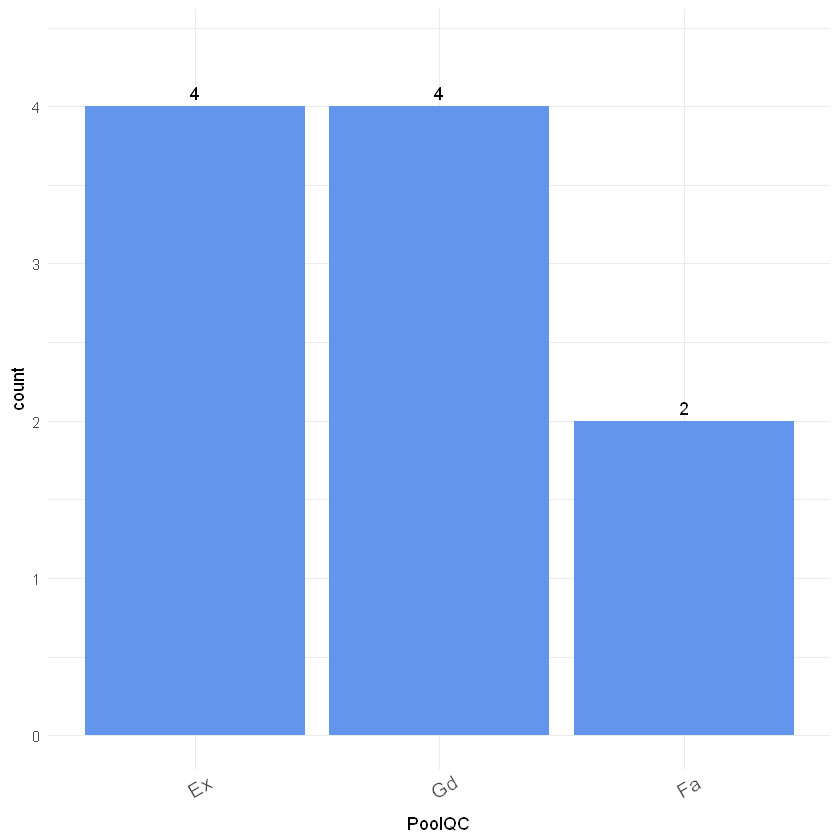

In [23]:
plot.categoric('PoolQC', df.combined)

In [26]:
# Of the 2909 houses with NA’s for PoolQC only 3 recorded a PoolArea greater than 0. 
df.combined[(df.combined$PoolArea > 0) & is.na(df.combined$PoolQC),c('PoolQC','PoolArea')] 

,PoolQC,PoolArea
2421,NA,368
2504,NA,444
2600,NA,561


In [35]:
aggregate(data = df.combined, PoolArea~PoolQC, mean)

PoolQC,PoolArea
Ex,359.75
Fa,583.50
Gd,648.50


In [46]:
"Note that only 10 houses total have pools The rest of the houses PoolQC can be filled with ‘NoPool’ since each has a corresponding PoolArea of 0. We’ll fill in the 3 PoolQC’s from above with the quality having the closest corresponding mean."

[1] "Note that only 10 houses total have pools The rest of the houses PoolQC can be filled with NoPool since each has a corresponding PoolArea of 0. Well fill in the 3 PoolQCs from above with the quality having the closest corresponding mean."

In [42]:
df.combined[2421,'PoolQC'] = 'Ex'
df.combined[2504,'PoolQC'] = 'Ex'
df.combined[2600,'PoolQC'] = 'Fa'
df.combined$PoolQC[is.na(df.combined$PoolQC)] = 'None'

In [59]:
#GarageType: Garage location
#GarageYrBlt: Year garage was built
#GarageFinish: Interior finish of the garage
#GarageCars: Size of garage in car capacity
#GarageArea: Size of garage in square feet
#GarageQual: Garage quality
#GarageCond: Garage condition
"Lets see what the deal is with GarageYrBlt. It seems reasonable that most houses would build a garage when the house itself was built. We can check this by seeing how many houses were built the same year their garage was built."

[1] "Lets see what the deal is with GarageYrBlt. It seems reasonable that most houses would build a garage when the house itself was built. We can check this by seeing how many houses were built the same year their garage was built."

In [47]:
length(which(df.combined$GarageYrBlt == df.combined$YearBuilt))

[1] 2216

In [48]:
"2216 of the 2919 houses have same year for for GarageYrBlt and YearBuilt. Lets replace any of the NA’s for GarageYrBlt with the year from YearBuilt."

[1] "2216 of the 2919 houses have same year for for GarageYrBlt and YearBuilt. Lets replace any of the NAs for GarageYrBlt with the year from YearBuilt."

In [49]:
idx <- which(is.na(df.combined$GarageYrBlt))
df.combined[idx, 'GarageYrBlt'] <- df.combined[idx, 'YearBuilt']

In [50]:
"That leaves 6 garage features in our dataset and 4 of them have at least 157 missing values while GarageArea and GarageCars both only have 1, thus we can assume this particular house does not have a garage at all. For the rest of the houses we can check to see that if the NA’s recorded also have 0 GarageArea and 0 GarageCars. If they do we can fill in their missing values with ‘None’ since having 0 area and 0 cars in their garage will imply that they do not have any at all."

[1] "That leaves 6 garage features in our dataset and 4 of them have at least 157 missing values while GarageArea and GarageCars both only have 1, thus we can assume this particular house does not have a garage at all. For the rest of the houses we can check to see that if the NAs recorded also have 0 GarageArea and 0 GarageCars. If they do we can fill in their missing values with None since having 0 area and 0 cars in their garage will imply that they do not have any at all."

In [51]:
garage.cols <- c('GarageArea', 'GarageCars', 'GarageQual', 'GarageFinish', 'GarageCond', 'GarageType')
df.combined[is.na(df.combined$GarageCond),garage.cols]

,GarageArea,GarageCars,GarageQual,GarageFinish,GarageCond,GarageType
40,0,0,NA,NA,NA,NA
49,0,0,NA,NA,NA,NA
79,0,0,NA,NA,NA,NA
89,0,0,NA,NA,NA,NA
90,0,0,NA,NA,NA,NA
100,0,0,NA,NA,NA,NA
109,0,0,NA,NA,NA,NA
126,0,0,NA,NA,NA,NA
128,0,0,NA,NA,NA,NA
141,0,0,NA,NA,NA,NA


In [52]:
"Only one house who had NA’s in their garage columns had an area graeteer than 0. We can fill this house in manually and set the rest of the houses NA’s to 0.

For the house with GarageArea = 360 and GarageCars = 1, but NA’s in the other columns, we can use the most frequent values for each columns from houses with a similar area and car count."

[1] "Only one house who had NAs in their garage columns had an area graeteer than 0. We can fill this house in manually and set the rest of the houses NAs to 0.\n\nFor the house with GarageArea = 360 and GarageCars = 1, but NAs in the other columns, we can use the most frequent values for each columns from houses with a similar area and car count."

In [53]:
idx <- which(((df.combined$GarageArea < 370) & (df.combined$GarageArea > 350)) & (df.combined$GarageCars == 1))

names(sapply(df.combined[idx, garage.cols], function(x) sort(table(x), decreasing=TRUE)[1]))

[1] "GarageArea.352"    "GarageCars.1"      "GarageQual.TA"    
[4] "GarageFinish.Unf"  "GarageCond.TA"     "GarageType.Attchd"

In [54]:
df.combined[2127,'GarageQual'] = 'TA'
df.combined[2127, 'GarageFinish'] = 'Unf'
df.combined[2127, 'GarageCond'] = 'TA'

In [56]:
"Now we can fill in any missing numeric values with 0 and categoric with ‘None’ since these houses recorded having 0 area and 0 cars in their garage."

[1] "Now we can fill in any missing numeric values with 0 and categoric with None since these houses recorded having 0 area and 0 cars in their garage."

In [57]:
for (col in garage.cols){
  if (sapply(df.combined[col], is.numeric) == TRUE){
    df.combined[sapply(df.combined[col], is.na), col] = 0
  }
  else{
    df.combined[sapply(df.combined[col], is.na), col] = 'None'
  }
}

In [60]:
#KitchenQual: Kitchen quality
#Electrical: Electrical system
"With only 1 missing value for KitchenQual and Electrical each we can fill in the missing value with the most frequent value from each column."

[1] "With only 1 missing value for KitchenQual and Electrical each we can fill in the missing value with the most frequent value from each column."

Warning message:
"Removed 1 rows containing non-finite values (stat_count)."Warning message:
"Removed 1 rows containing non-finite values (stat_count)."Warning message:
"Removed 1 rows containing non-finite values (stat_count)."

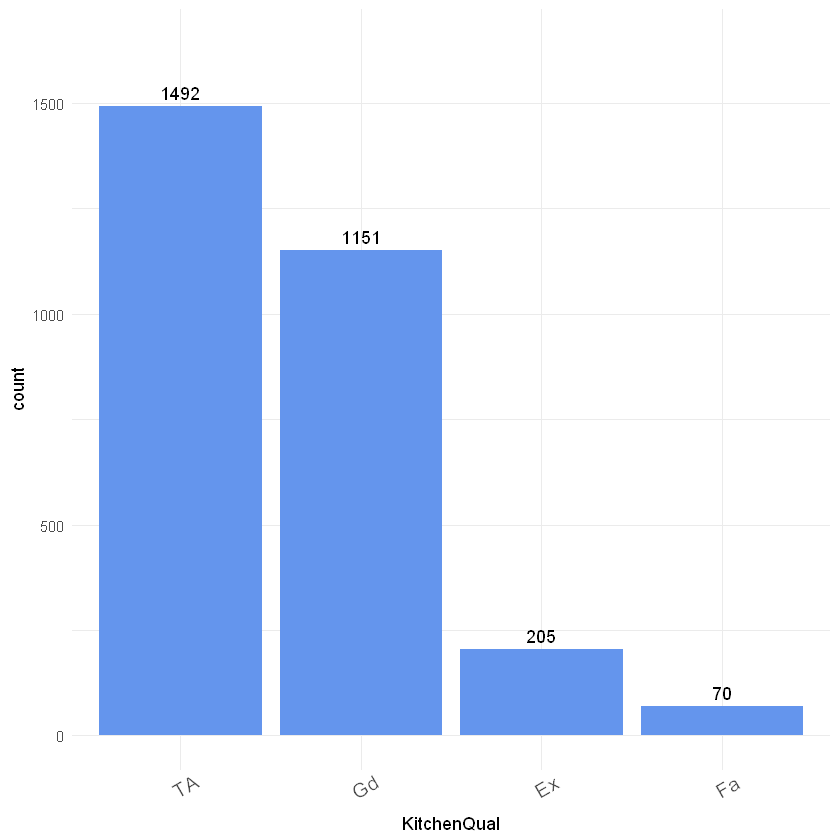

In [61]:
plot.categoric('KitchenQual', df.combined)

Warning message:
"Removed 1 rows containing non-finite values (stat_count)."Warning message:
"Removed 1 rows containing non-finite values (stat_count)."Warning message:
"Removed 1 rows containing non-finite values (stat_count)."

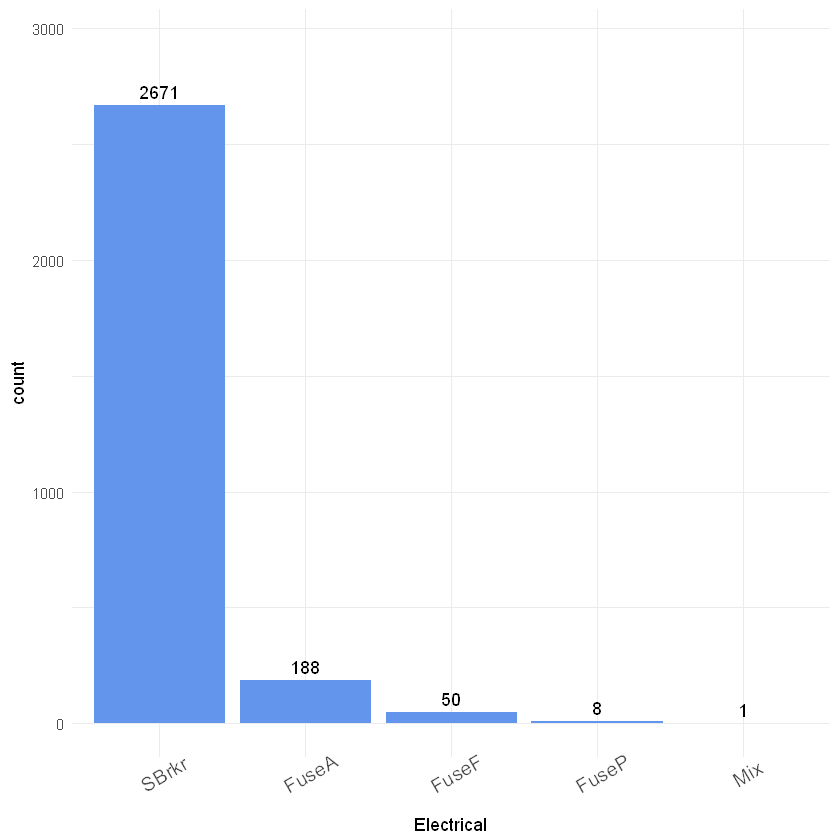

In [62]:
df.combined$KitchenQual[is.na(df.combined$KitchenQual)] = 'TA'

plot.categoric('Electrical', df.combined)

In [63]:
df.combined$Electrical[is.na(df.combined$Electrical)] = 'SBrkr'

In [64]:
#BsmtQual: Height of the basement
#BsmtCond: General condition of the basement
#BsmtExposure: Walkout or garden level basement walls
#BsmtFinType1: Quality of basement finished area
#BsmtFinSF1: Type 1 finished square feet
#BsmtFinType2: Quality of second finished area (if present)
#BsmtFinSF2: Type 2 finished square feet
#BsmtUnfSF: Unfinished square feet of basement area
#TotalBsmtSF: Total square feet of basement area
#BsmtFullBath: Basement full bathrooms
#BsmtHalfBath: Basement half bathrooms
"There are 11 basement features each with at least 1 missing value. We can take a look at the subset of just these columns from our data."

[1] "There are 11 basement features each with at least 1 missing value. We can take a look at the subset of just these columns from our data."

In [65]:
bsmt.cols <- names(df.combined)[sapply(names(df.combined), function(x) str_detect(x, 'Bsmt'))]

df.combined[is.na(df.combined$BsmtExposure),bsmt.cols]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
18,NA,NA,NA,NA,0,NA,0,0,0,0,0
40,NA,NA,NA,NA,0,NA,0,0,0,0,0
91,NA,NA,NA,NA,0,NA,0,0,0,0,0
103,NA,NA,NA,NA,0,NA,0,0,0,0,0
157,NA,NA,NA,NA,0,NA,0,0,0,0,0
183,NA,NA,NA,NA,0,NA,0,0,0,0,0
260,NA,NA,NA,NA,0,NA,0,0,0,0,0
343,NA,NA,NA,NA,0,NA,0,0,0,0,0
363,NA,NA,NA,NA,0,NA,0,0,0,0,0
372,NA,NA,NA,NA,0,NA,0,0,0,0,0


Warning message:
"Removed 82 rows containing non-finite values (stat_count)."Warning message:
"Removed 82 rows containing non-finite values (stat_count)."Warning message:
"Removed 82 rows containing non-finite values (stat_count)."

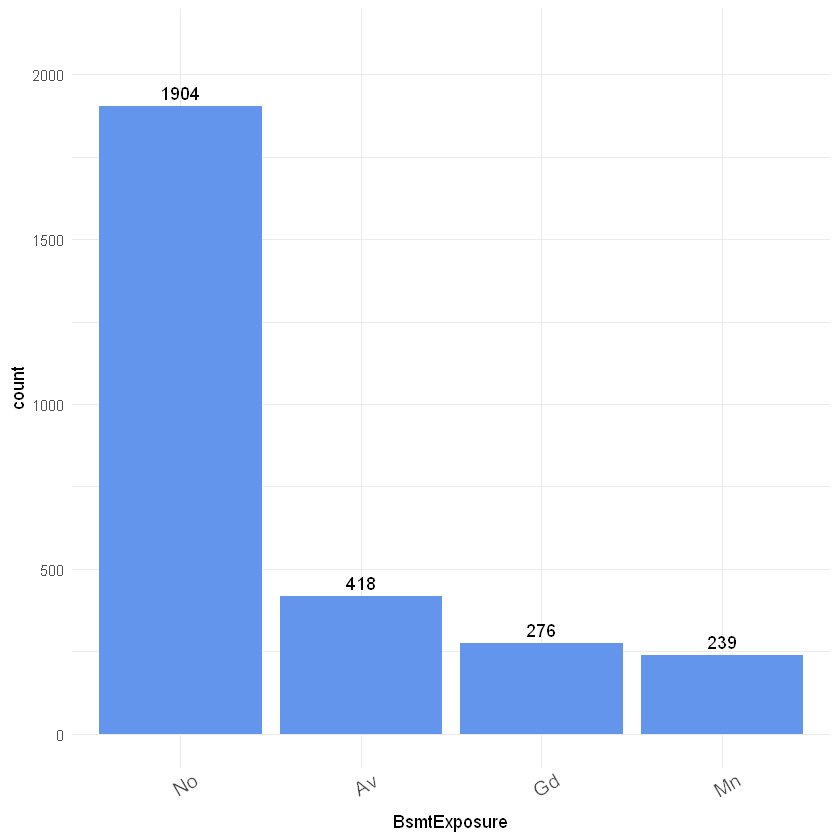

In [66]:
plot.categoric('BsmtExposure', df.combined)

In [67]:
"Almost all of the missing values for each categoric basement feature comes from houses with 0 on each features corresponding to area. We can fill in these values with ‘None’ since these houses certainly don’t have basements. Rows 949, 1488 and 2349 are the only missing values from BsmtExposure, we can fill this with No as that is the most frequent value and these houses most likely don’t have any exposure for their basements. The rest of the basement columns corresponding to area will be filled with 0 since they likely don’t have a basement and the categoric missing values will be filled with NoBsmt."

[1] "Almost all of the missing values for each categoric basement feature comes from houses with 0 on each features corresponding to area. We can fill in these values with None since these houses certainly dont have basements. Rows 949, 1488 and 2349 are the only missing values from BsmtExposure, we can fill this with No as that is the most frequent value and these houses most likely dont have any exposure for their basements. The rest of the basement columns corresponding to area will be filled with 0 since they likely dont have a basement and the categoric missing values will be filled with NoBsmt."

In [68]:
df.combined[c(949, 1488, 2349), 'BsmtExposure'] = 'No'

for (col in bsmt.cols){
  if (sapply(df.combined[col], is.numeric) == TRUE){
    df.combined[sapply(df.combined[col], is.na),col] = 0
  }
  else{
    df.combined[sapply(df.combined[col],is.na),col] = 'None'
  }
}

In [69]:
#Exterior1st: Exterior covering on house
#Exterior2nd: Exterior covering on house (if more than one material)

In [70]:
#plot.categoric(c('Exterior1st', 'Exterior2nd'), df.combined)
idx <- which(is.na(df.combined$Exterior1st) | is.na(df.combined$Exterior2nd))
df.combined[idx,c('Exterior1st', 'Exterior2nd')]

,Exterior1st,Exterior2nd
2152,NA,NA


In [71]:
"There is only 1 missing value for Exterior1st and Exterior2nd coming from the same hosue and there aren’t any other features that can help us predict what variable should be filled so we can fill this with ‘Other’ since the NA is likely due to having an exterior cover that is not listed."

[1] "There is only 1 missing value for Exterior1st and Exterior2nd coming from the same hosue and there arent any other features that can help us predict what variable should be filled so we can fill this with Other since the NA is likely due to having an exterior cover that is not listed."

In [72]:
df.combined$Exterior1st[is.na(df.combined$Exterior1st)] = 'Other'
df.combined$Exterior2nd[is.na(df.combined$Exterior2nd)] = 'Other'

In [74]:
#SaleType: Type of sale
#Functional: Home functionality rating
#Utilities: Type of utilities available
"SaleType, Functional and Utilities have less than 3 missing values. For SaleType we can see what the SaleCondition of the house was and use a contingency table to see which SaleType and SaleCondition overlap together the most."

[1] "SaleType, Functional and Utilities have less than 3 missing values. For SaleType we can see what the SaleCondition of the house was and use a contingency table to see which SaleType and SaleCondition overlap together the most."

Warning message:
"Removed 1 rows containing non-finite values (stat_count)."Warning message:
"Removed 1 rows containing non-finite values (stat_count)."Warning message:
"Removed 1 rows containing non-finite values (stat_count)."

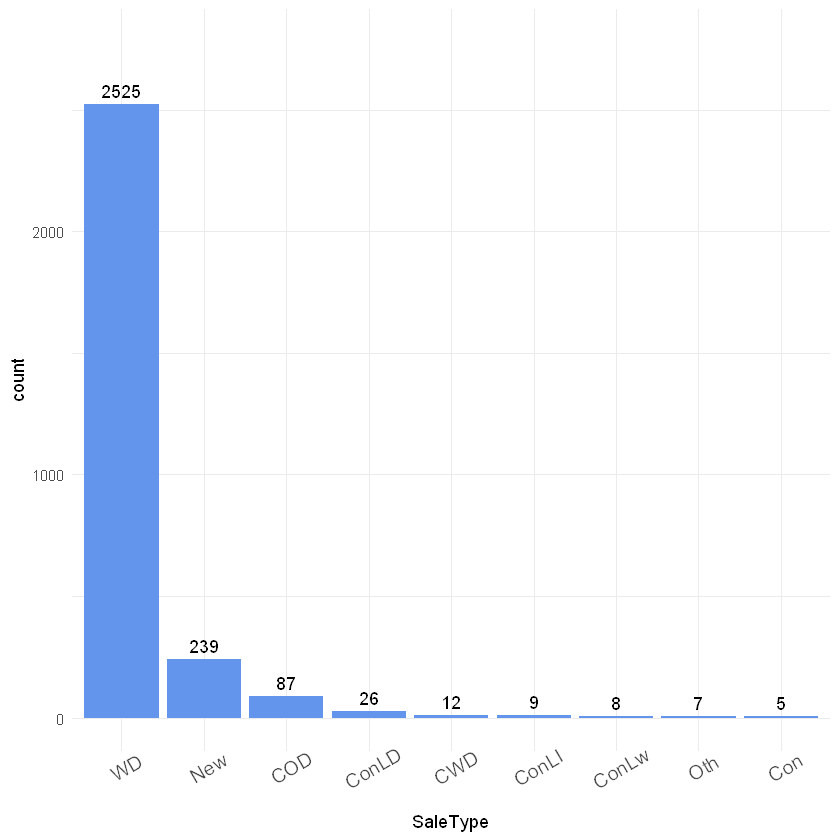

In [75]:
plot.categoric('SaleType', df.combined)

In [76]:
df.combined[is.na(df.combined$SaleType),c('SaleCondition')]

[1] "Normal"

In [77]:
table(df.combined$SaleCondition, df.combined$SaleType)

         
           COD  Con ConLD ConLI ConLw  CWD  New  Oth   WD
  Abnorml   46    0     3     2     0    1    0    5  133
  AdjLand    0    0     0     0     0    0    0    0   12
  Alloca     0    0     0     0     0    0    0    0   24
  Family     2    0     1     2     1    1    0    1   38
  Normal    39    4    21     5     7   10    0    1 2314
  Partial    0    1     1     0     0    0  239    0    4

In [78]:
"Most houses with a SaleCondition of ‘Normal’ almost all have a SaleType of ‘WD’. We’ll replace the missing value accordingly."

[1] "Most houses with a SaleCondition of Normal almost all have a SaleType of WD. Well replace the missing value accordingly."

Warning message:
"Removed 2 rows containing non-finite values (stat_count)."Warning message:
"Removed 2 rows containing non-finite values (stat_count)."Warning message:
"Removed 2 rows containing non-finite values (stat_count)."

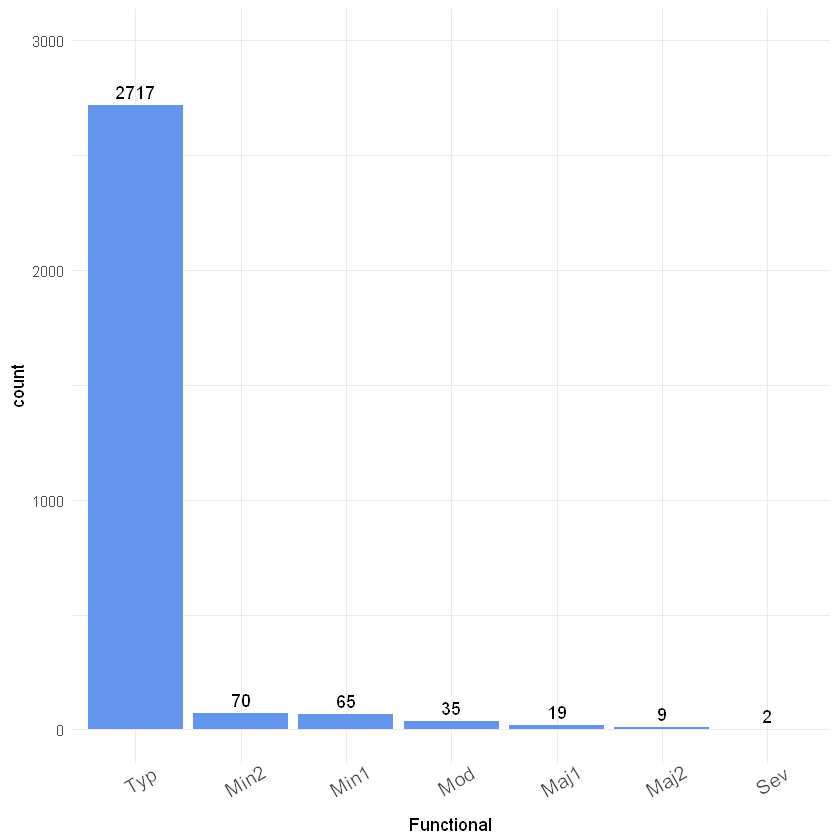

In [79]:
df.combined$SaleType[is.na(df.combined$SaleType)] = 'WD'

plot.categoric('Functional', df.combined)

In [80]:
df.combined$Functional[is.na(df.combined$Functional)] = 'Typ'

In [81]:
"Utilities only has 1 value for NoSeWa and the rest AllPub. We can drop this feature from our dataset as the house with ‘NoSeWa’ is from our training set and will have won’t help with any predictive modelling"

[1] "Utilities only has 1 value for NoSeWa and the rest AllPub. We can drop this feature from our dataset as the house with NoSeWa is from our training set and will have wont help with any predictive modelling"

Warning message:
"Removed 2 rows containing non-finite values (stat_count)."Warning message:
"Removed 2 rows containing non-finite values (stat_count)."Warning message:
"Removed 2 rows containing non-finite values (stat_count)."

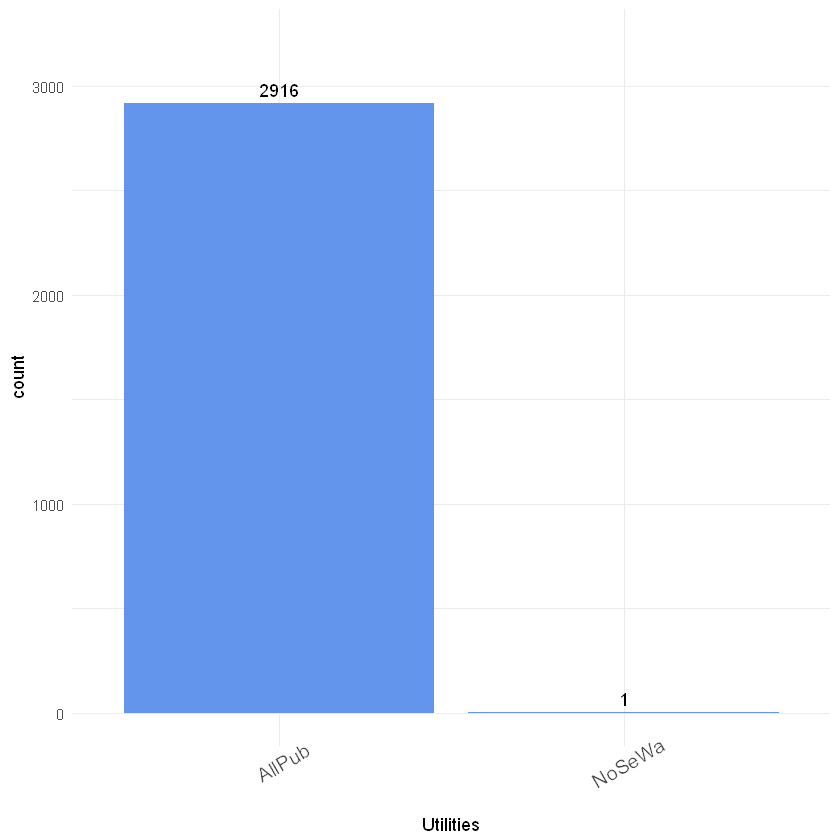

In [82]:
plot.categoric('Utilities', df.combined)

In [83]:
which(df.combined$Utilities == 'NoSeWa') # in the training data set

[1] 945

In [84]:
col.drops <- c('Utilities')
df.combined <- df.combined[,!names(df.combined) %in% c('Utilities')]

In [85]:
#MSZoning: The general zoning classification
#MSSubClass: The building class
"There are only 4 missing values for MSZoning. We can see what the subclass is for the houses with missing values for Zoning."

[1] "There are only 4 missing values for MSZoning. We can see what the subclass is for the houses with missing values for Zoning."

In [86]:
df.combined[is.na(df.combined$MSZoning),c('MSZoning','MSSubClass')]

,MSZoning,MSSubClass
1916,NA,30
2217,NA,20
2251,NA,70
2905,NA,20


Warning message:
"Removed 4 rows containing non-finite values (stat_count)."Warning message:
"Removed 4 rows containing non-finite values (stat_count)."Warning message:
"Removed 4 rows containing non-finite values (stat_count)."

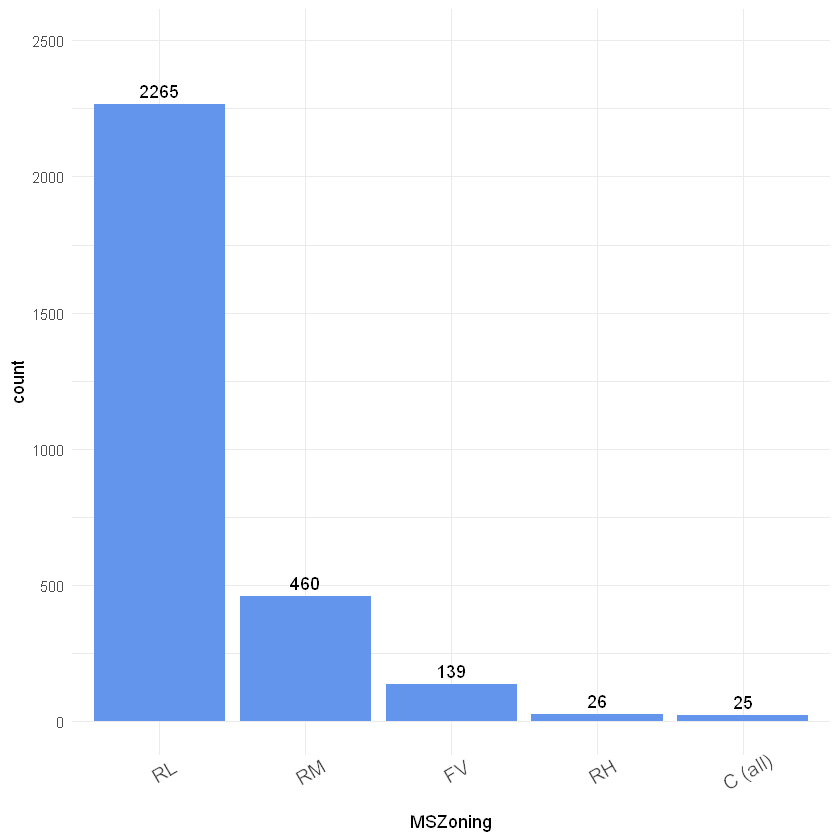

In [87]:
plot.categoric('MSZoning', df.combined)

In [88]:
table(df.combined$MSZoning, df.combined$MSSubClass)

         
            20   30   40   45   50   60   70   75   80   85   90  120  150  160
  C (all)    3    8    0    0    7    0    4    0    0    0    0    0    0    0
  FV        34    0    0    0    0   43    0    0    0    0    0   19    0   43
  RH         4    2    0    1    2    0    3    0    0    0    4    6    0    0
  RL      1016   61    4    6  159  529   57    9  115   47   92  117    1   21
  RM        20   67    2   11  119    3   63   14    3    1   13   40    0   64
         
           180  190
  C (all)    0    3
  FV         0    0
  RH         0    4
  RL         0   31
  RM        17   23

In [89]:
"For Subclasses with 20 ‘RL’ has the largest frequency, however, for Subclasses with 30 and 70 ‘RM’ has the most frequency. We will fill the missing values accordingly."

[1] "For Subclasses with 20 RL has the largest frequency, however, for Subclasses with 30 and 70 RM has the most frequency. We will fill the missing values accordingly."

In [90]:
df.combined$MSZoning[c(2217, 2905)] = 'RL'
df.combined$MSZoning[c(1916, 2251)] = 'RM'

In [92]:
#MasVnrType: Masonry veneer type
#MasVnrArea: Masonry veneer area in square feet
"There are 23 missing values for MasVnrArea and 24 for MasVnrType. We can see if both missing values come from the same houses"

[1] "There are 23 missing values for MasVnrArea and 24 for MasVnrType. We can see if both missing values come from the same houses"

In [93]:
df.combined[(is.na(df.combined$MasVnrType)) | (is.na(df.combined$MasVnrArea)), c('MasVnrType', 'MasVnrArea')]

,MasVnrType,MasVnrArea
235,NA,NA
530,NA,NA
651,NA,NA
937,NA,NA
974,NA,NA
978,NA,NA
1244,NA,NA
1279,NA,NA
1692,NA,NA
1707,NA,NA


In [94]:
"All but one house has missing values for both columns. For houses with NA’s on both columns we can fill 0 for the area and None for the type since they likely do not have a masonry veneer. For the house with a MasVnrArea of 198 but NA for MasVnrType we can record the median areas for each type and see which type is closest to 198"

[1] "All but one house has missing values for both columns. For houses with NAs on both columns we can fill 0 for the area and None for the type since they likely do not have a masonry veneer. For the house with a MasVnrArea of 198 but NA for MasVnrType we can record the median areas for each type and see which type is closest to 198"

In [95]:
na.omit(df.combined[,c('MasVnrType','MasVnrArea')]) %>%
  group_by(na.omit(MasVnrType)) %>%
  summarise(MedianArea = median(MasVnrArea,na.rm = TRUE), counts = n()) %>%
  arrange(MedianArea)

na.omit(MasVnrType),MedianArea,counts
None,0,1742
BrkCmn,161,25
Stone,200,249
BrkFace,203,879


In [96]:
#plot.categoric('MasVnrType', df.combined)

df.combined[2611, 'MasVnrType'] = 'BrkFace'

In [97]:
df.combined$MasVnrType[is.na(df.combined$MasVnrType)] = 'None'
df.combined$MasVnrArea[is.na(df.combined$MasVnrArea)] = 0

In [98]:
#LotFrontage: Linear feet of street connected to property
"There are 486 missing values for LotFrontage, which is quite a lot of values to fill and we can’t just replace these with 0. We’re given that “LotFrontage: Linear feet of street connected to property.” The area of each street connected to the house property is most likely going to have a similar area to other houses in its neighborhood. We can group by each neighborhood and take the median of each LotFrontage and fill the missing values of each LotFrontage based on what neighborhood the house comes from."

[1] "There are 486 missing values for LotFrontage, which is quite a lot of values to fill and we cant just replace these with 0. Were given that LotFrontage: Linear feet of street connected to property. The area of each street connected to the house property is most likely going to have a similar area to other houses in its neighborhood. We can group by each neighborhood and take the median of each LotFrontage and fill the missing values of each LotFrontage based on what neighborhood the house comes from."

In [103]:
df.combined['Nbrh.factor'] <- factor(df.combined$Neighborhood, levels = unique(df.combined$Neighborhood))

lot.by.nbrh <- aggregate(data = df.combined, LotFrontage~Neighborhood, median, na.rm = TRUE)
lot.by.nbrh

Neighborhood,LotFrontage
Blmngtn,43.0
Blueste,24.0
BrDale,21.0
BrkSide,51.0
ClearCr,80.5
CollgCr,70.0
Crawfor,70.0
Edwards,65.0
Gilbert,64.0
IDOTRR,60.0


In [104]:
idx = which(is.na(df.combined$LotFrontage))

for (i in idx){
  lot.median <- lot.by.nbrh[lot.by.nbrh == df.combined$Neighborhood[i],'median']
  df.combined[i,'LotFrontage'] <- lot.median[[1]]
}

Warning message:
"Removed 2348 rows containing non-finite values (stat_count)."Warning message:
"Removed 2348 rows containing non-finite values (stat_count)."Warning message:
"Removed 2348 rows containing non-finite values (stat_count)."

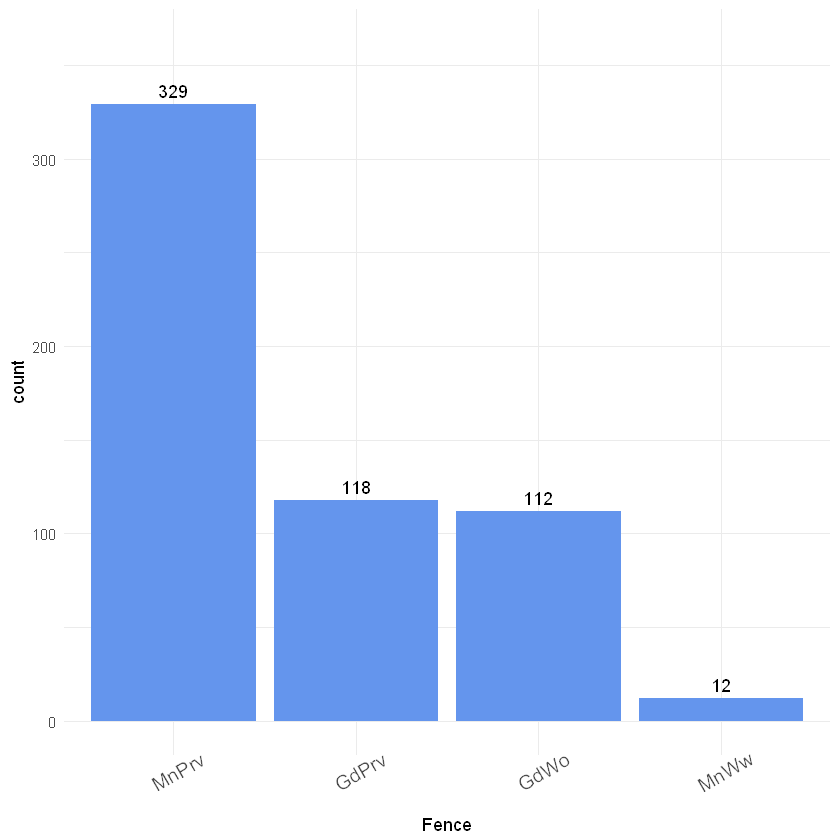

In [105]:
# Fence: Fence quality
plot.categoric('Fence', df.combined)

In [106]:
df.combined$Fence[is.na(df.combined$Fence)] = 'None'


table(df.combined$MiscFeature)


Gar2 Othr Shed TenC 
   5    4   95    1 

In [107]:
df.combined$MiscFeature[is.na(df.combined$MiscFeature)] = 'None'

In [108]:
#Fireplaces: Number of fireplaces
#FireplaceQu: Fireplace quality
"FireplaceQu denotes the fireplace quality. We can check to see if any of the missing values for FireplaceQu come from houses that recorded having at least 1 fireplace."

[1] "FireplaceQu denotes the fireplace quality. We can check to see if any of the missing values for FireplaceQu come from houses that recorded having at least 1 fireplace."

Warning message:
"Removed 1420 rows containing non-finite values (stat_count)."Warning message:
"Removed 1420 rows containing non-finite values (stat_count)."Warning message:
"Removed 1420 rows containing non-finite values (stat_count)."

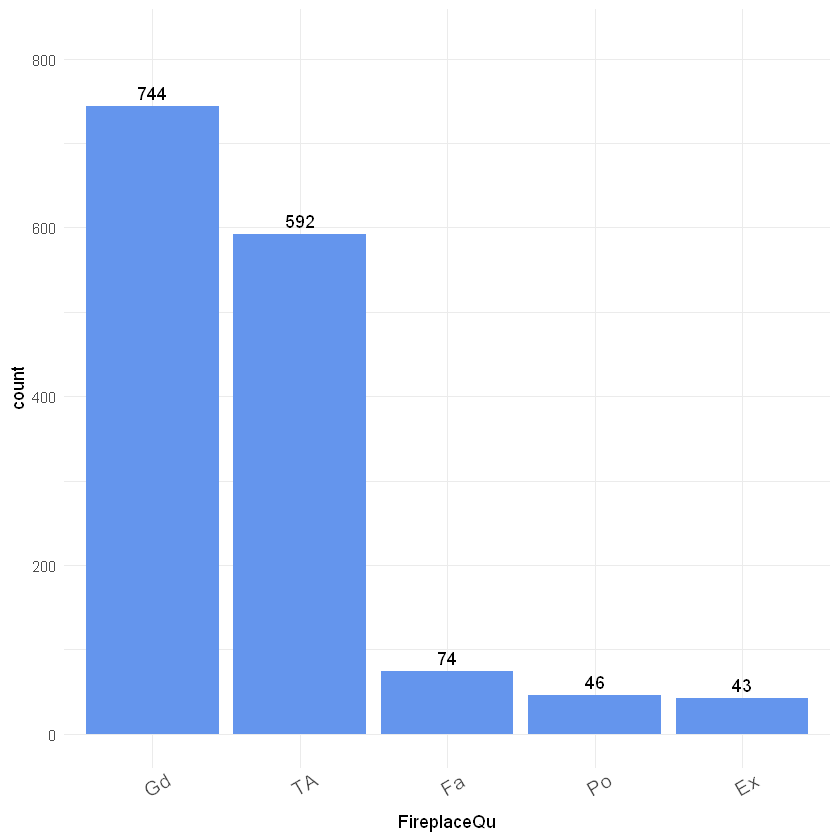

In [109]:
plot.categoric('FireplaceQu', df.combined)

In [110]:
which((df.combined$Fireplaces > 0) & (is.na(df.combined$FireplaceQu)))

integer(0)

In [111]:
"All the houses that have missing values did not record having any fireplaces. We can replace the NA’s with ‘None’ since these houses don’t have any fireplaces at all."

[1] "All the houses that have missing values did not record having any fireplaces. We can replace the NAs with None since these houses dont have any fireplaces at all."

In [112]:
df.combined$FireplaceQu[is.na(df.combined$FireplaceQu)] = 'None'

In [114]:
#Alley: Type of alley access
"There are 2721 missing values for Alley and only 2 potential options - Grvl and Pave. We can fill ‘None’ for any of the houses with NA’s as these houses must not have any type of alley access."

[1] "There are 2721 missing values for Alley and only 2 potential options - Grvl and Pave. We can fill None for any of the houses with NAs as these houses must not have any type of alley access."

Warning message:
"Removed 2721 rows containing non-finite values (stat_count)."Warning message:
"Removed 2721 rows containing non-finite values (stat_count)."Warning message:
"Removed 2721 rows containing non-finite values (stat_count)."

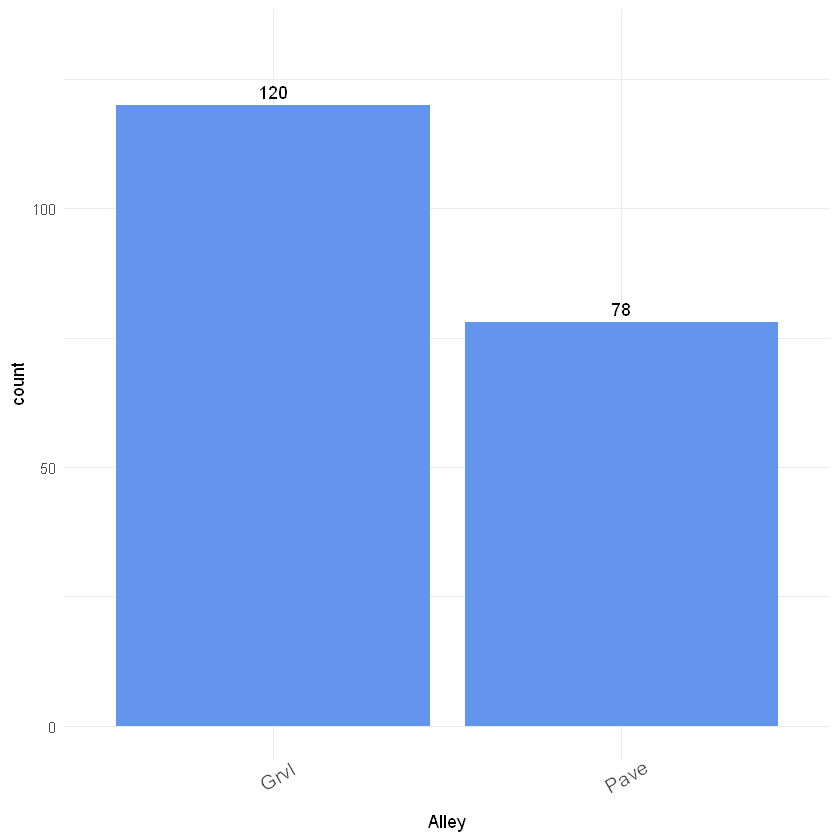

In [115]:
plot.categoric('Alley', df.combined)

In [116]:
df.combined$Alley[is.na(df.combined$Alley)] = 'None'

In [117]:
cat('There are', sum(sapply(df.combined, is.na)), 'missing values left')

There are 0 missing values left

In [118]:
# Adding custom numeric features
"Splitting data into a numeric set and a categoric set. Since we want our dataset to be strictly numeric values while retaining as much information as possible, we will have to transform any categoric into a binary feature using one-hot encoding."

[1] "Splitting data into a numeric set and a categoric set. Since we want our dataset to be strictly numeric values while retaining as much information as possible, we will have to transform any categoric into a binary feature using one-hot encoding."

In [119]:
num_features <- names(which(sapply(df.combined, is.numeric)))
cat_features <- names(which(sapply(df.combined, is.character)))

df.numeric <- df.combined[num_features]

In [120]:
"We can transform any of the ordinal variables (variables that can be scaled) into numeric values. We can do this by determining which order the categories follow and assigning the values an order from 1,2,..,n. We’ll group each feature by its possible values and return the median SalePrice and mean OverallQual for each unique value, then map the higher priced/better quality homes larger numeric values and the lower priced/lower quality homes smaller numeric values."

[1] "We can transform any of the ordinal variables (variables that can be scaled) into numeric values. We can do this by determining which order the categories follow and assigning the values an order from 1,2,..,n. Well group each feature by its possible values and return the median SalePrice and mean OverallQual for each unique value, then map the higher priced/better quality homes larger numeric values and the lower priced/lower quality homes smaller numeric values."

In [121]:
group.df <- df.combined[1:1460,]
group.df$SalePrice <- train$SalePrice
      
# function that groups a column by its features and returns the mdedian saleprice for each unique feature. 
group.prices <- function(col) {
  group.table <- group.df[,c(col, 'SalePrice', 'OverallQual')] %>%
    group_by_(col) %>%
    summarise(mean.Quality = round(mean(OverallQual),2),
      mean.Price = mean(SalePrice), n = n()) %>%
    arrange(mean.Quality)
    
  print(qplot(x=reorder(group.table[[col]], -group.table[['mean.Price']]), y=group.table[['mean.Price']]) +
    geom_bar(stat='identity', fill='cornflowerblue') +
    theme_minimal() +
    scale_y_continuous(labels = dollar) +
    labs(x=col, y='Mean SalePrice') +
    theme(axis.text.x = element_text(angle = 45)))
  
  return(data.frame(group.table))
}

## functional to compute the mean overall quality for each quality
quality.mean <- function(col) {
  group.table <- df.combined[,c(col, 'OverallQual')] %>%
    group_by_(col) %>%
    summarise(mean.qual = mean(OverallQual)) %>%
    arrange(mean.qual)
  
  return(data.frame(group.table))
}

# function that maps a categoric value to its corresponding numeric value and returns that column to the data frame
map.fcn <- function(cols, map.list, df){
  for (col in cols){
    df[col] <- as.numeric(map.list[df.combined[,col]])
  }
  return(df)
}

In [122]:
"Any of the columns with the suffix ‘Qual’ or ‘Cond’ denote the quality or condition of that specific feature. Each of these columns have the potential values: TA, Fa, Gd, None, Ex, Po. We’ll compute the mean house prices for these unique values to get a better sense of what their abbreviations mean."

[1] "Any of the columns with the suffix Qual or Cond denote the quality or condition of that specific feature. Each of these columns have the potential values: TA, Fa, Gd, None, Ex, Po. Well compute the mean house prices for these unique values to get a better sense of what their abbreviations mean."

FireplaceQu,mean.Quality,mean.Price,n
Po,4.95,129764.1,20
None,5.46,141331.5,690
Fa,5.76,167298.5,33
TA,6.48,205723.5,313
Gd,6.89,226351.4,380
Ex,8.38,337712.5,24


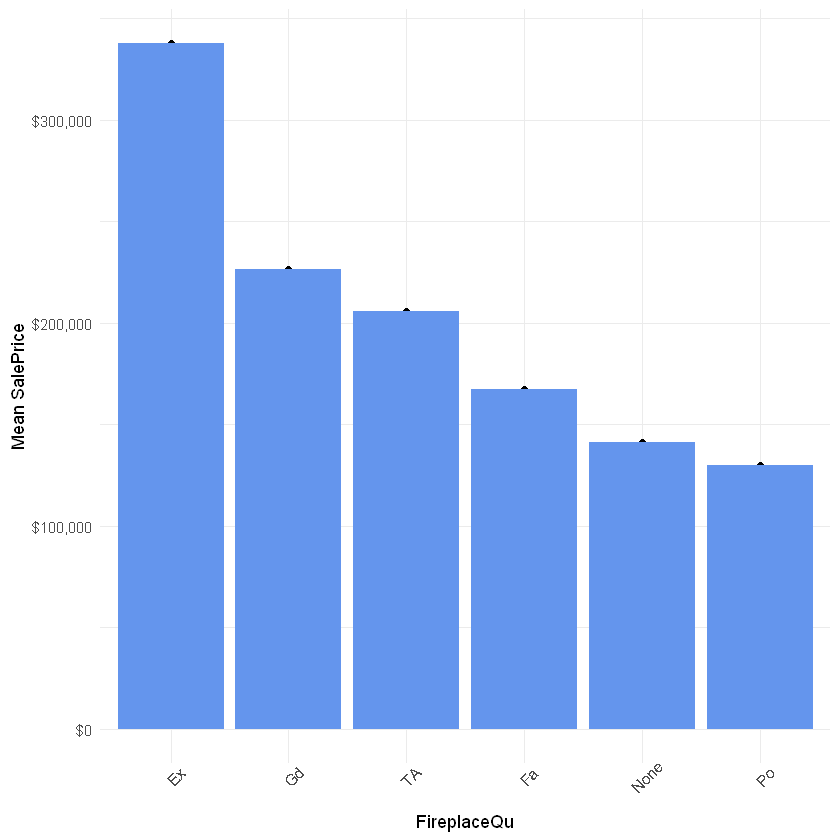

In [123]:
qual.cols <- c('ExterQual', 'ExterCond', 'GarageQual', 'GarageCond', 'FireplaceQu', 'KitchenQual', 'HeatingQC', 'BsmtQual')

group.prices('FireplaceQu')

BsmtQual,mean.Quality,mean.Price,n
None,4.30,105652.9,37
Fa,4.89,115692.0,35
TA,5.33,140759.8,649
Gd,6.66,202688.5,618
Ex,8.26,327041.0,121


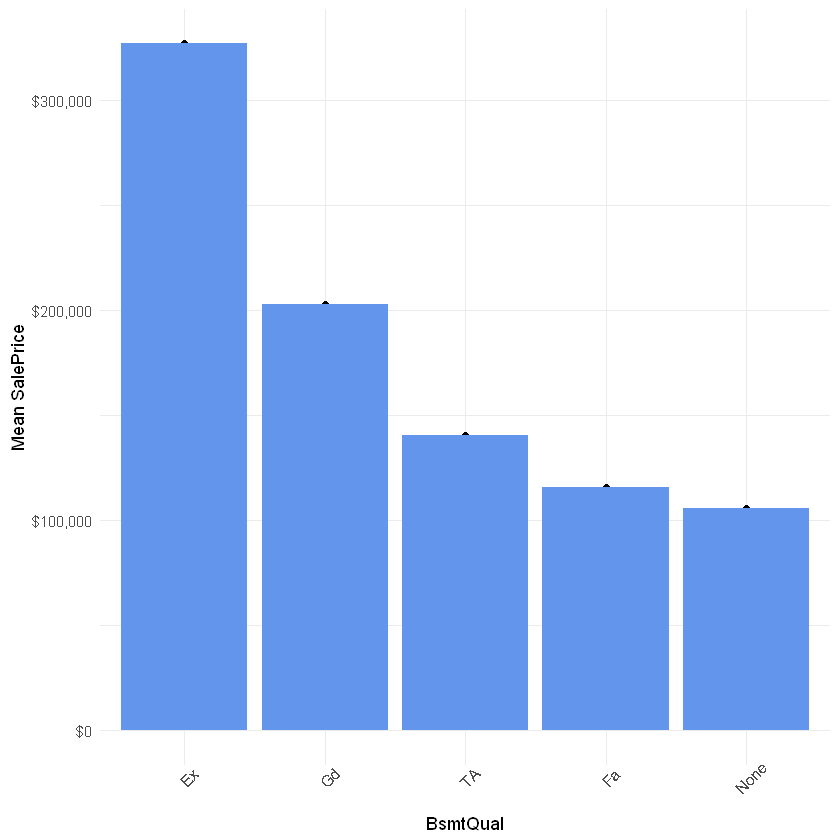

In [124]:
group.prices('BsmtQual')

KitchenQual,mean.Quality,mean.Price,n
Fa,4.49,105565.2,39
TA,5.34,139962.5,735
Gd,6.79,212116.0,586
Ex,8.27,328554.7,100


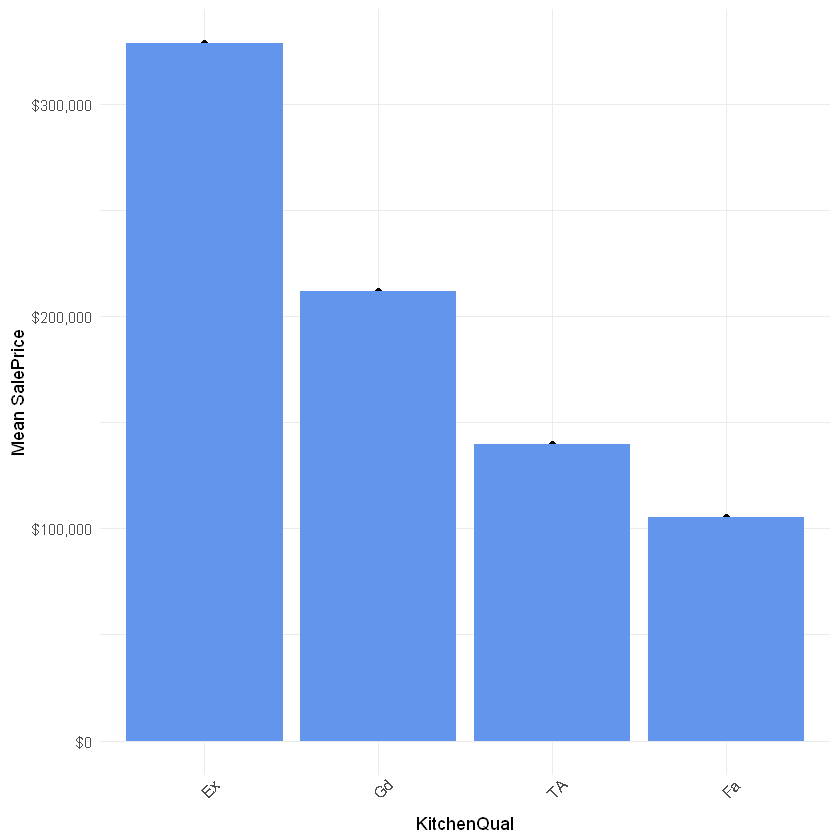

In [125]:
group.prices('KitchenQual')

In [126]:
"From seeing the mean saleprices from a few of the quality and condition features we can infer that the abbreviations mean poor, fair, typical/average, good and excelent. We’ll map numeric values from 0-5 to their corresponding categoric values (including 0 for None) and combine that to our dataframe.

Note: we will set ‘None’ = 0 for all categories as None signifies that the house does not have that particular quality/condition to rank and regardless of the houses overall quality or sale price we will keep ‘None’ = 0 for consistency."

[1] "From seeing the mean saleprices from a few of the quality and condition features we can infer that the abbreviations mean poor, fair, typical/average, good and excelent. Well map numeric values from 0-5 to their corresponding categoric values (including 0 for None) and combine that to our dataframe.\n\nNote: we will set None = 0 for all categories as None signifies that the house does not have that particular quality/condition to rank and regardless of the houses overall quality or sale price we will keep None = 0 for consistency."

In [127]:
qual.list <- c('None' = 0, 'Po' = 1, 'Fa' = 2, 'TA' = 3, 'Gd' = 4, 'Ex' = 5)

df.numeric <- map.fcn(qual.cols, qual.list, df.numeric)

BsmtExposure,mean.Quality,mean.Price,n
None,4.30,105652.9,37
No,5.92,165680.4,954
Mn,6.25,192789.7,114
Av,6.57,206643.4,221
Gd,6.96,257689.8,134


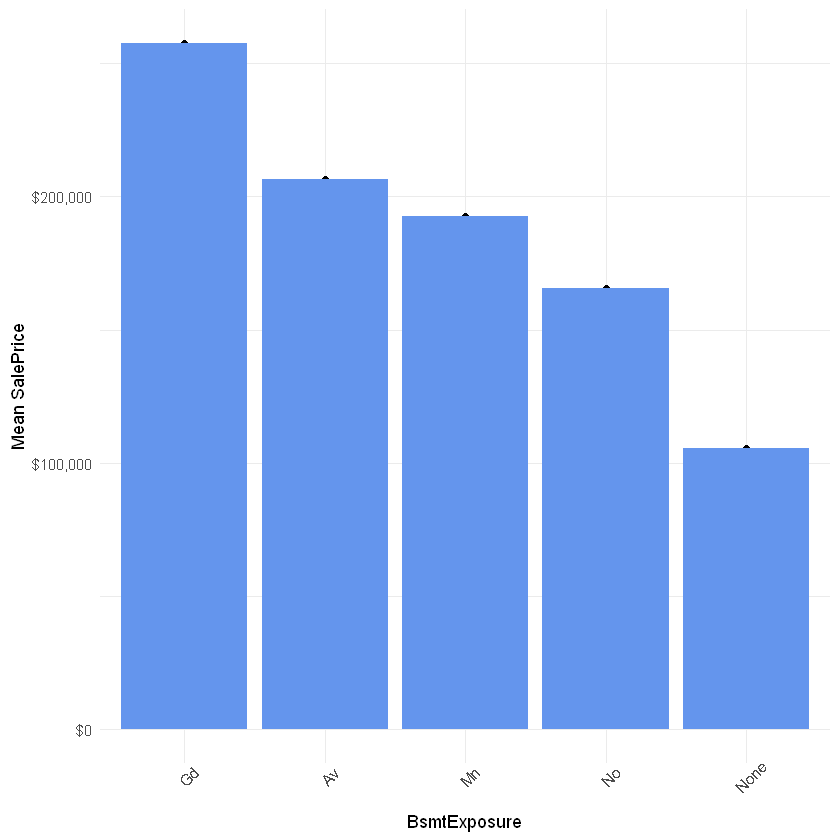

In [128]:
group.prices('BsmtExposure')

In [129]:
bsmt.list <- c('None' = 0, 'No' = 1, 'Mn' = 2, 'Av' = 3, 'Gd' = 4)

df.numeric = map.fcn(c('BsmtExposure'), bsmt.list, df.numeric)

BsmtFinType1,mean.Quality,mean.Price,n
None,4.30,105652.9,37
BLQ,5.35,149493.7,148
Rec,5.35,146889.2,133
LwQ,5.54,151852.7,74
ALQ,5.55,161573.1,220
Unf,6.20,170670.6,430
GLQ,7.05,235413.7,418


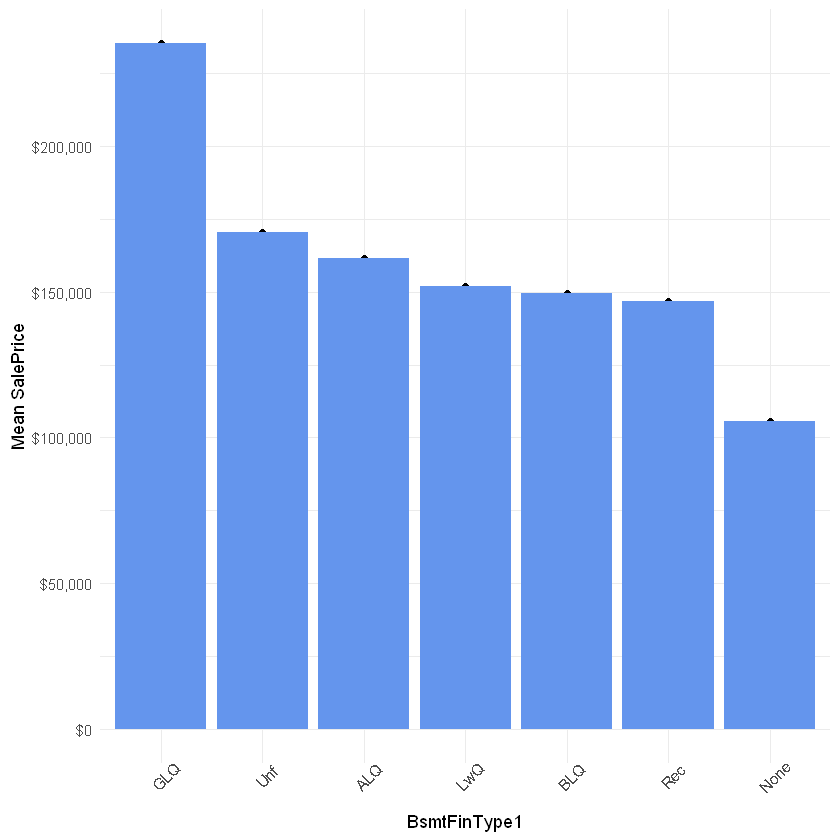

In [130]:
group.prices('BsmtFinType1')

In [131]:
#BsmtFinType1: Quality of basement finished area
#BsmtFinSF1: Type 1 finished square feet
"Here returning the mean sale prices might not be as helpful as computing the median basement areas for both columns to determine which quality is better than the other."

[1] "Here returning the mean sale prices might not be as helpful as computing the median basement areas for both columns to determine which quality is better than the other."

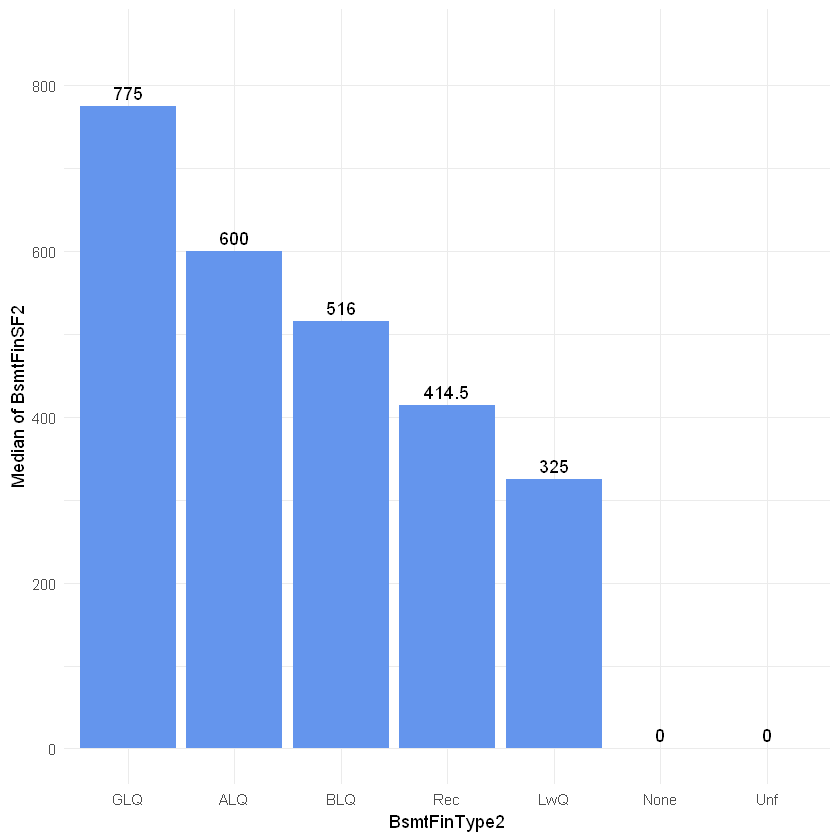

In [132]:
# visualization for BsmtFinTyp2 instead of another table
df.combined[,c('BsmtFinType1', 'BsmtFinSF1')] %>%
  group_by(BsmtFinType1) %>%
  summarise(medianArea = median(BsmtFinSF1), counts = n()) %>%
  arrange(medianArea) %>%
  ggplot(aes(x=reorder(BsmtFinType1,-medianArea), y=medianArea)) +
  geom_bar(stat = 'identity', fill='cornflowerblue') +
  labs(x='BsmtFinType2', y='Median of BsmtFinSF2') +
  geom_text(aes(label = sort(medianArea)), vjust = -0.5) +
  scale_y_continuous(limits = c(0,850)) +
  theme_minimal()

In [134]:
 "Through investigating the relationships between the basement quality and areas we an see the true order of qualities of each basement to be ‘None’ < ‘Unf’ < ‘LwQ’ < ‘BLQ’ < ‘Rec’ < ‘ALQ’ < ‘GLQ’."

[1] "Through investigating the relationships between the basement quality and areas we an see the true order of qualities of each basement to be None < Unf < LwQ < BLQ < Rec < ALQ < GLQ."

In [135]:
bsmt.fin.list <- c('None' = 0, 'Unf' = 1, 'LwQ' = 2,'Rec'= 3, 'BLQ' = 4, 'ALQ' = 5, 'GLQ' = 6)
df.numeric <- map.fcn(c('BsmtFinType1','BsmtFinType2'), bsmt.fin.list, df.numeric)

In [137]:
#Functional: Home functionality rating
"This feature doesn’t really tell us much and functionality is very vague to tie which other features have a correlation with it. We can compute the mean sale prices for each functional category and assign numeric values accordingly."

[1] "This feature doesnt really tell us much and functionality is very vague to tie which other features have a correlation with it. We can compute the mean sale prices for each functional category and assign numeric values accordingly."

Functional,mean.Quality,mean.Price,n
Min2,4.97,144240.6,34
Maj2,5.00,85800.0,5
Min1,5.26,146385.5,31
Mod,5.40,168393.3,15
Maj1,5.50,153948.1,14
Sev,6.00,129000.0,1
Typ,6.16,183429.1,1360


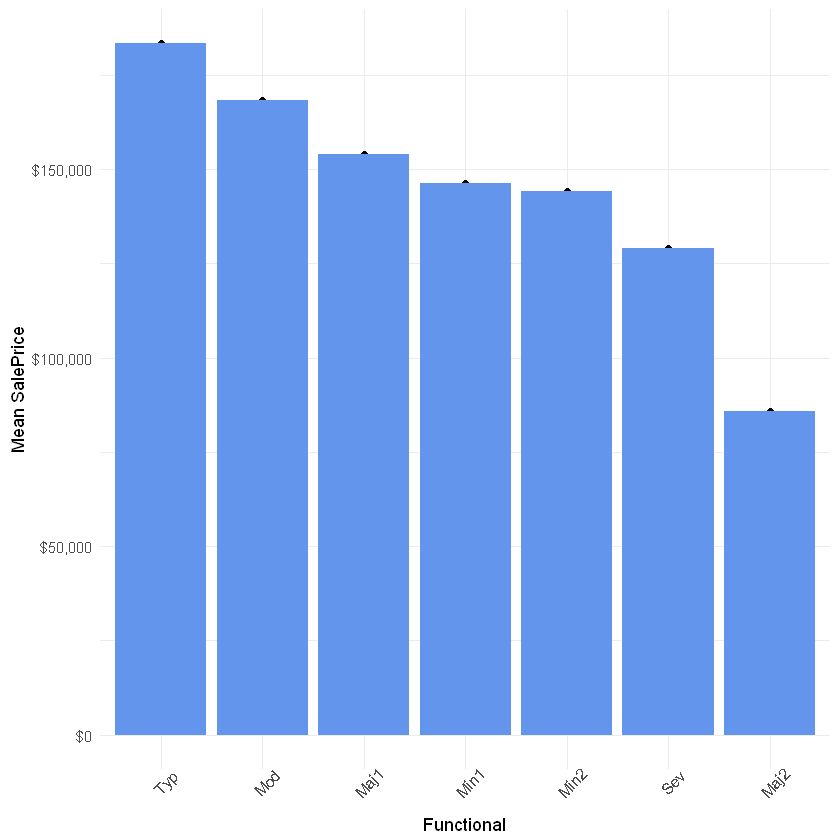

In [138]:
group.prices('Functional')

In [139]:
functional.list <- c('None' = 0, 'Sal' = 1, 'Sev' = 2, 'Maj2' = 3, 'Maj1' = 4, 'Mod' = 5, 'Min2' = 6, 'Min1' = 7, 'Typ'= 8)

df.numeric['Functional'] <- as.numeric(functional.list[df.combined$Functional])

In [140]:
"We’ll continue to do the same for GarageFinish and Fence:"

[1] "Well continue to do the same for GarageFinish and Fence:"

GarageFinish,mean.Quality,mean.Price,n
None,4.60,103317.3,81
Unf,5.40,142156.4,605
RFn,6.57,202068.9,422
Fin,7.07,240052.7,352


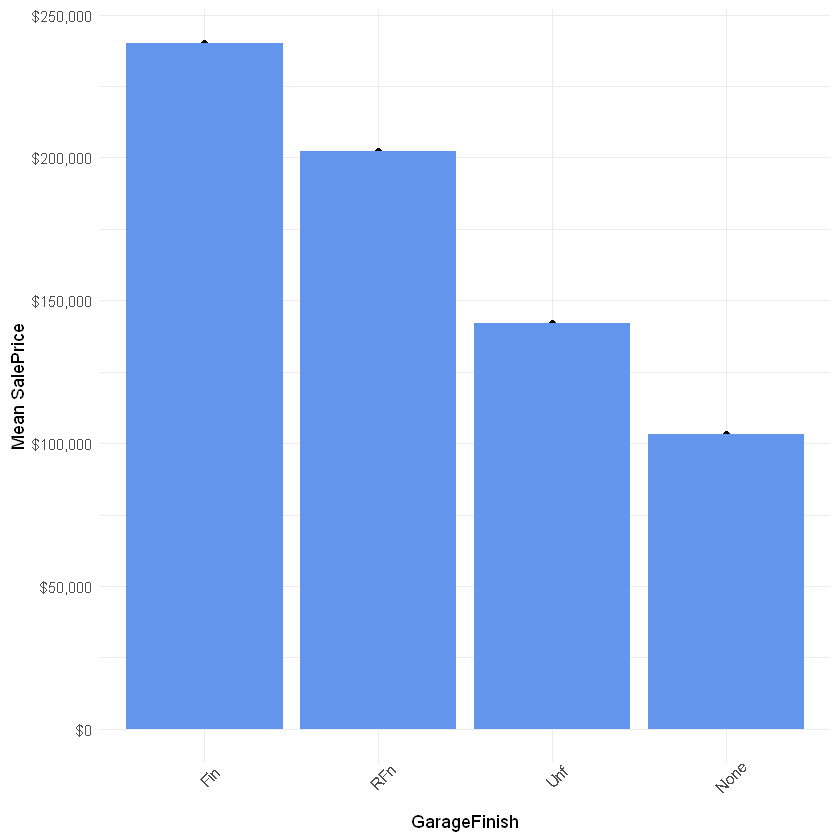

In [141]:
group.prices('GarageFinish')

Fence,mean.Quality,mean.Price,n
GdWo,5.17,140379.3,54
MnWw,5.18,134286.4,11
MnPrv,5.45,148751.1,157
None,6.23,187596.8,1179
GdPrv,6.31,178927.5,59


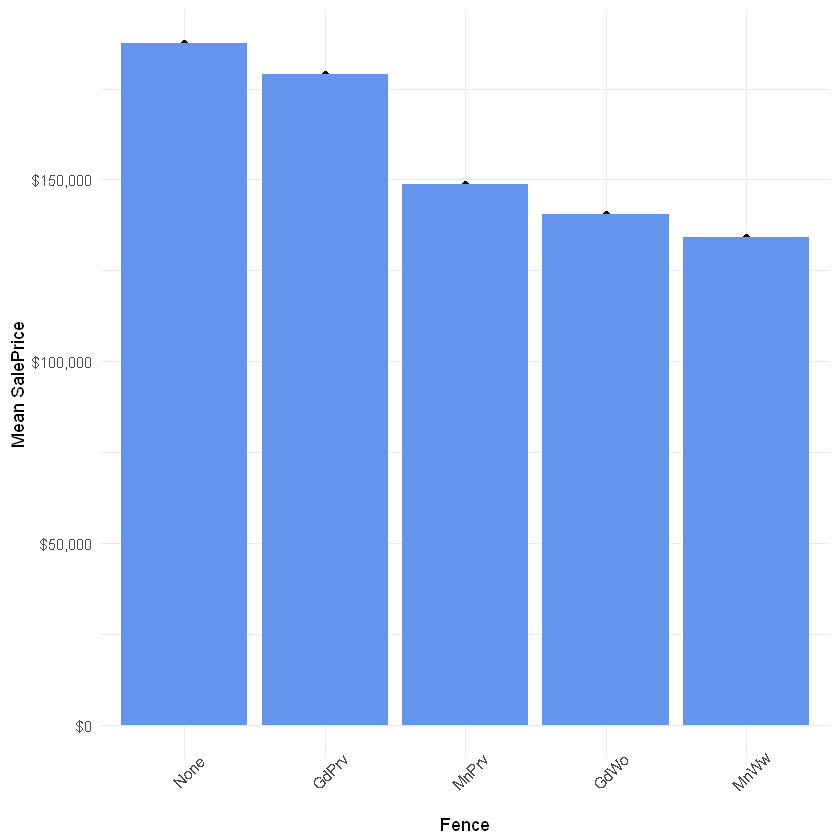

In [142]:
garage.fin.list <- c('None' = 0,'Unf' = 1, 'RFn' = 1, 'Fin' = 2)

df.numeric['GarageFinish'] <- as.numeric(garage.fin.list[df.combined$GarageFinish])


group.prices('Fence')

In [143]:
fence.list <- c('None' = 0, 'MnWw' = 1, 'GdWo' = 1, 'MnPrv' = 2, 'GdPrv' = 4)

df.numeric['Fence'] <- as.numeric(fence.list[df.combined$Fence])

MSdwelling.list <- c('20' = 1, '30'= 0, '40' = 0, '45' = 0,'50' = 0, '60' = 1, '70' = 0, '75' = 0, '80' = 0, '85' = 0, '90' = 0, '120' = 1, '150' = 0, '160' = 0, '180' = 0, '190' = 0)

df.numeric['NewerDwelling'] <- as.numeric(MSdwelling.list[as.character(df.combined$MSSubClass)])

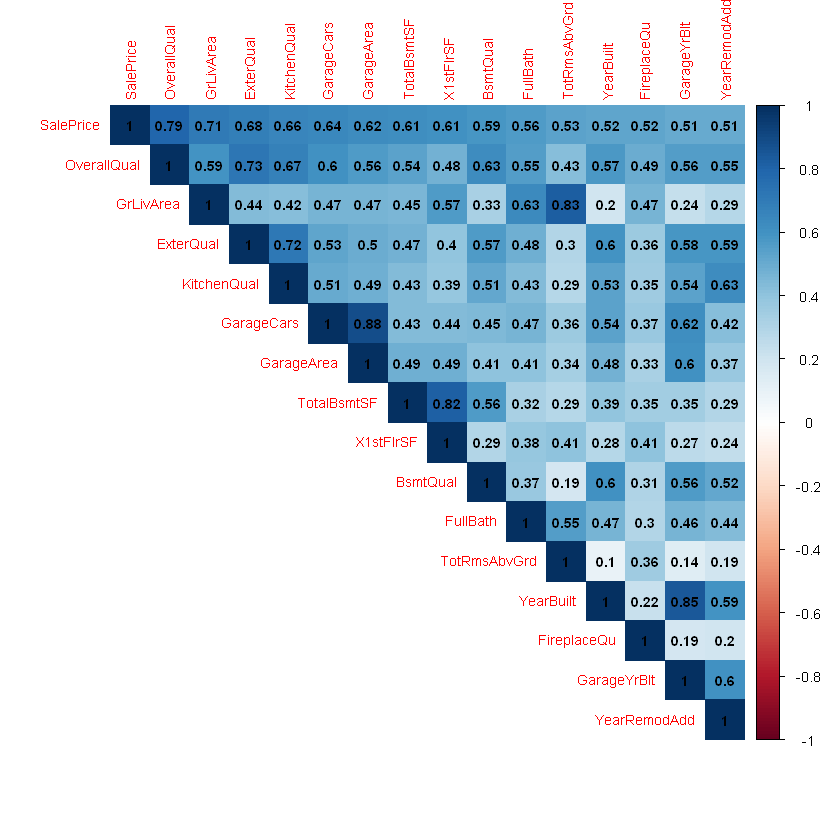

In [144]:
# Correlation
# need the SalePrice column
corr.df <- cbind(df.numeric[1:1460,], train['SalePrice'])

# only using the first 1460 rows - training data
correlations <- cor(corr.df)
# only want the columns that show strong correlations with SalePrice
corr.SalePrice <- as.matrix(sort(correlations[,'SalePrice'], decreasing = TRUE))

corr.idx <- names(which(apply(corr.SalePrice, 1, function(x) (x > 0.5 | x < -0.5))))

corrplot(as.matrix(correlations[corr.idx,corr.idx]), type = 'upper', method='color', addCoef.col = 'black', tl.cex = .7,cl.cex = .7, number.cex=.7)

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at 1.985"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 2.015"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  1.3045e-016"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 4.0602"Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at 1.985"Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 2.015"Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) obje

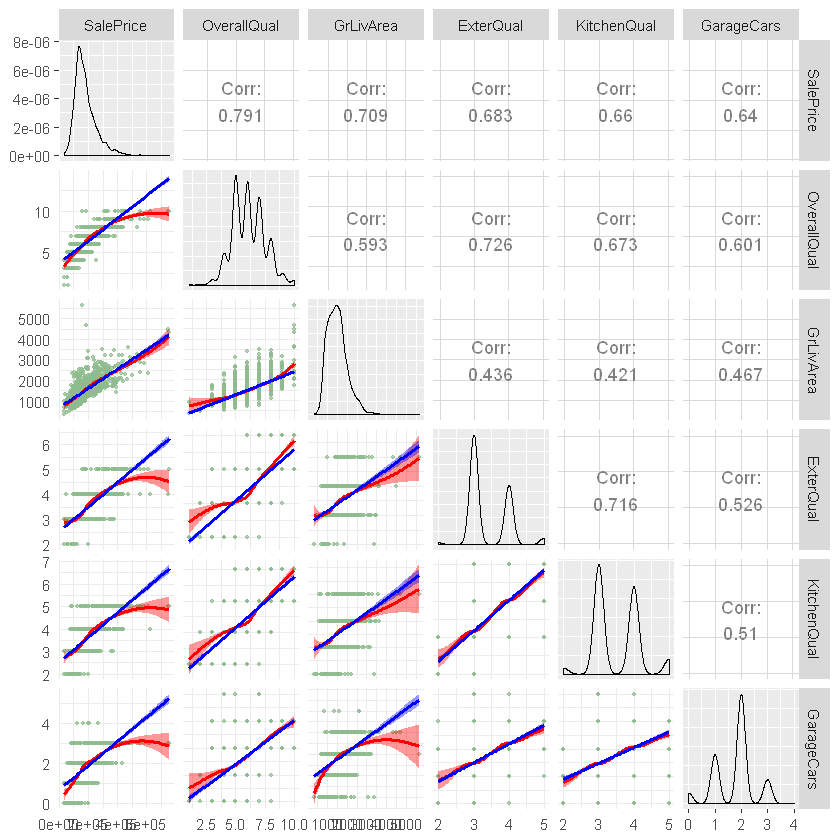

In [151]:
lm.plt <- function(data, mapping, ...){
   plt <- ggplot(data = data, mapping = mapping) + 
    geom_point(shape = 20, alpha = 0.7, color = 'darkseagreen') +
    geom_smooth(method=loess, fill="red", color="red") +
    geom_smooth(method=lm, fill="blue", color="blue") +
    theme_minimal()
  return(plt)
}

ggpairs(corr.df, corr.idx[1:6], lower = list(continuous = lm.plt))

In [152]:
"The blue lines in the scatter plots represent a simple linear regression fit while the red lines represent a local polynomial fit. We can see both OverallQual and GrLivArea and TotalBsmtSF follow a linear model, but have some outliers we may want to look into. For instance, there are multiple houses with an overall quality of 10, but have suspisciously low prices. We can see similar behavior in GrLivArea and TotalBsmtSF. GarageCars and GarageArea both follow more of a quadratic fit. It seems that having a 4 car garage does not result in a higher house price and same with an extremely large area."

[1] "The blue lines in the scatter plots represent a simple linear regression fit while the red lines represent a local polynomial fit. We can see both OverallQual and GrLivArea and TotalBsmtSF follow a linear model, but have some outliers we may want to look into. For instance, there are multiple houses with an overall quality of 10, but have suspisciously low prices. We can see similar behavior in GrLivArea and TotalBsmtSF. GarageCars and GarageArea both follow more of a quadratic fit. It seems that having a 4 car garage does not result in a higher house price and same with an extremely large area."

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at 5.025"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 2.025"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  1.1943e-016"Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 1"Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"pseudoinverse used at 5.025"Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
"neighborhood radius 2.025"Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x 

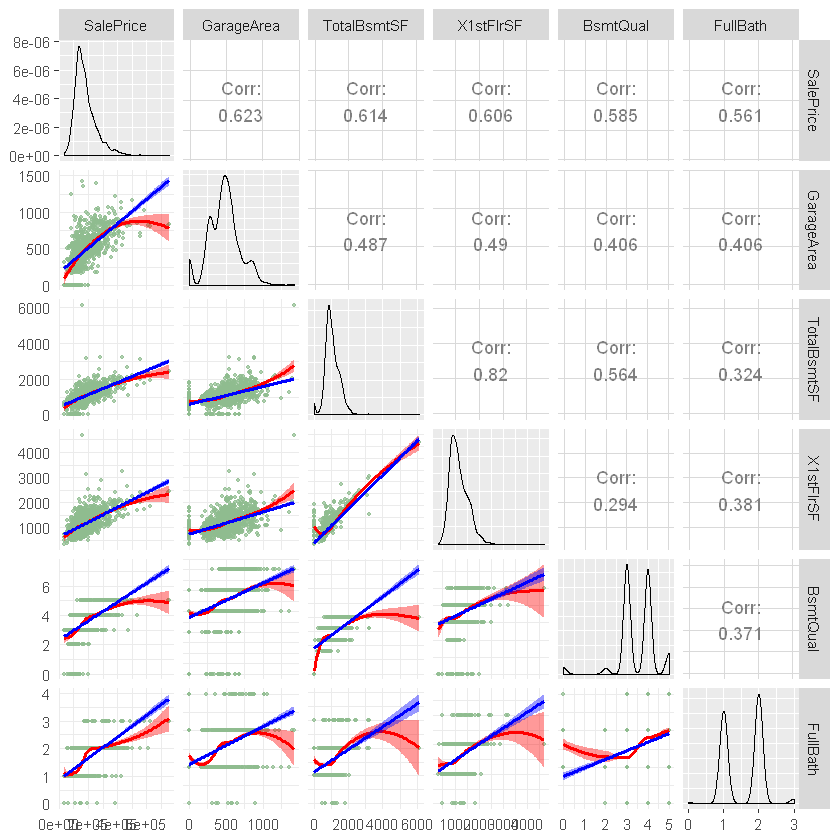

In [153]:
ggpairs(corr.df, corr.idx[c(1,7:11)], lower = list(continuous = lm.plt))

In [154]:
"More of the same with the remaining features with 1stFlrSF, FullBath, TotRmsAbvGrd following linear model while YearBuilt and YearRemodAdd both having non-linear/quadratic models. Taking a closer look to YearBuilt and YearRemodAdd we can see that the most expensive homes are the most recently built and remodelled."

[1] "More of the same with the remaining features with 1stFlrSF, FullBath, TotRmsAbvGrd following linear model while YearBuilt and YearRemodAdd both having non-linear/quadratic models. Taking a closer look to YearBuilt and YearRemodAdd we can see that the most expensive homes are the most recently built and remodelled."

In [155]:
"Now for some of the nominal variables we can take one of the categories that is distict from the others and create a binary feature that returns 1 if the house has that specific value and 0 if it does not."

[1] "Now for some of the nominal variables we can take one of the categories that is distict from the others and create a binary feature that returns 1 if the house has that specific value and 0 if it does not."

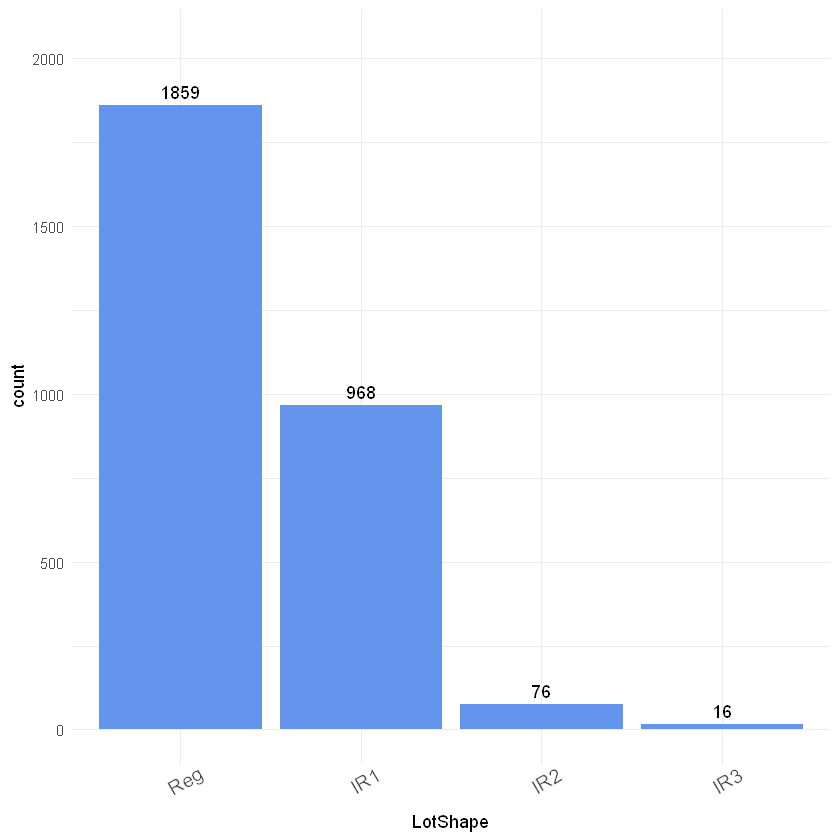

In [156]:
plot.categoric('LotShape', df.combined)

In [157]:
df.numeric['RegularLotShape'] <- (df.combined$LotShape == 'Reg') * 1

In [158]:
#LandContour: Flatness of the property
#LandSlope: Slope of property
#Electrical: Electrical system
#GarageType: Garage location
#PavedDrive: Paved driveway
#MiscFeature: Miscellaneous feature not covered in other categories

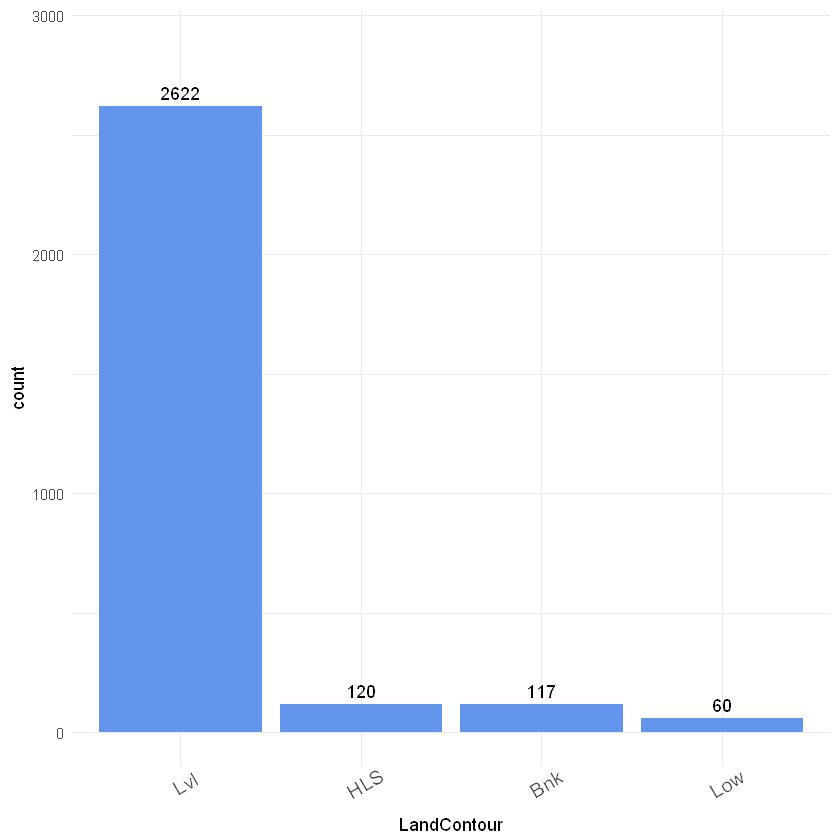

In [159]:
plot.categoric('LandContour', df.combined)

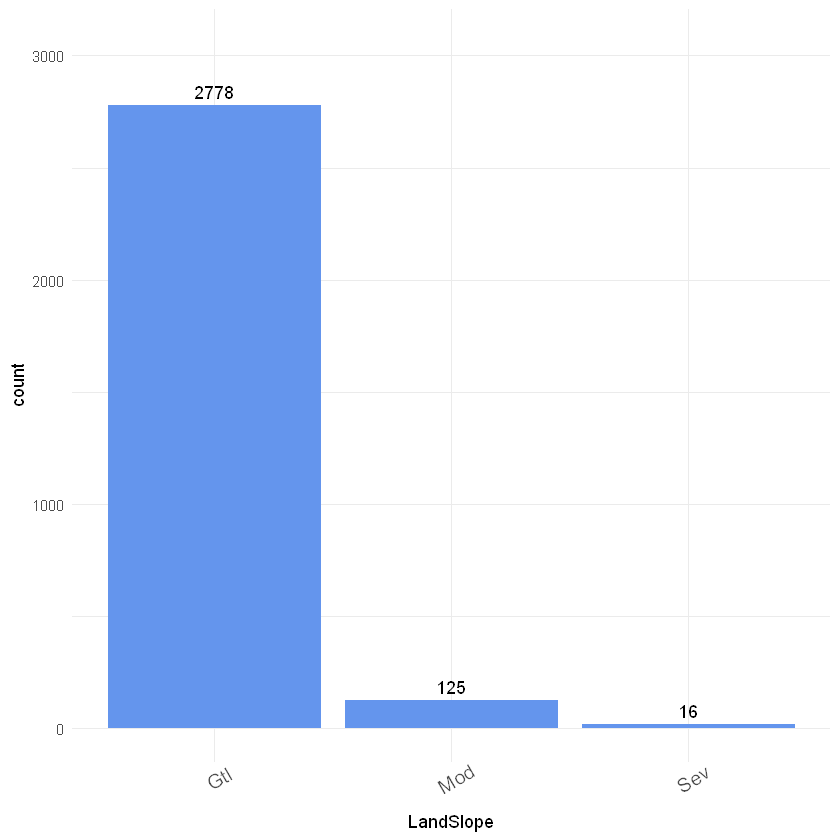

In [160]:
df.numeric['LandLeveled'] <- (df.combined$LandContour == 'Lvl') * 1

plot.categoric('LandSlope', df.combined)

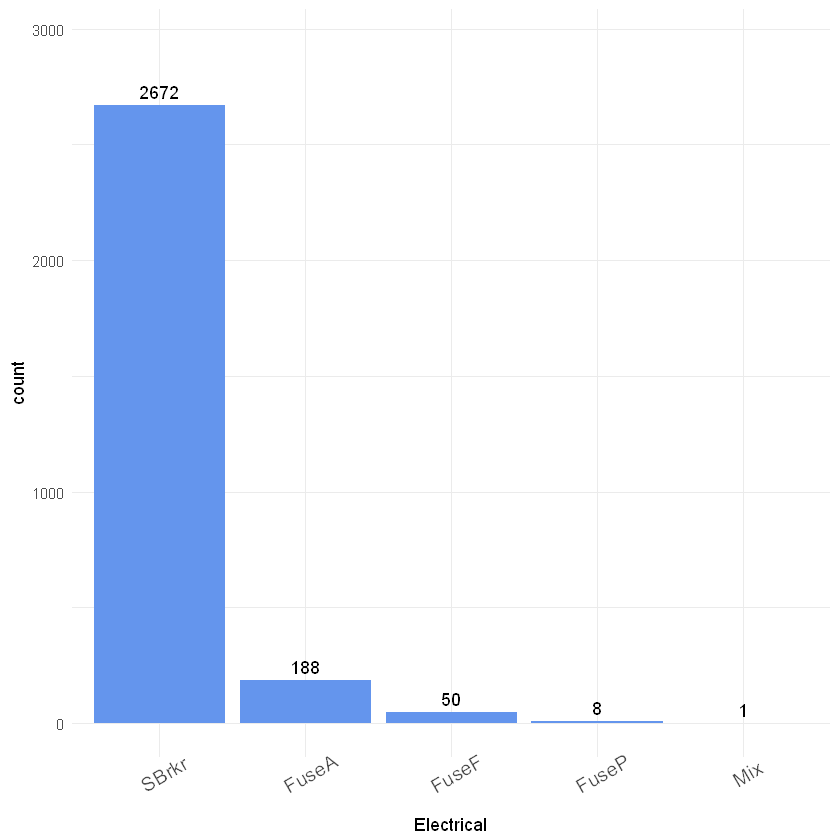

In [161]:
df.numeric['LandSlopeGentle'] <- (df.combined$LandSlope == 'Gtl') * 1

plot.categoric('Electrical', df.combined)

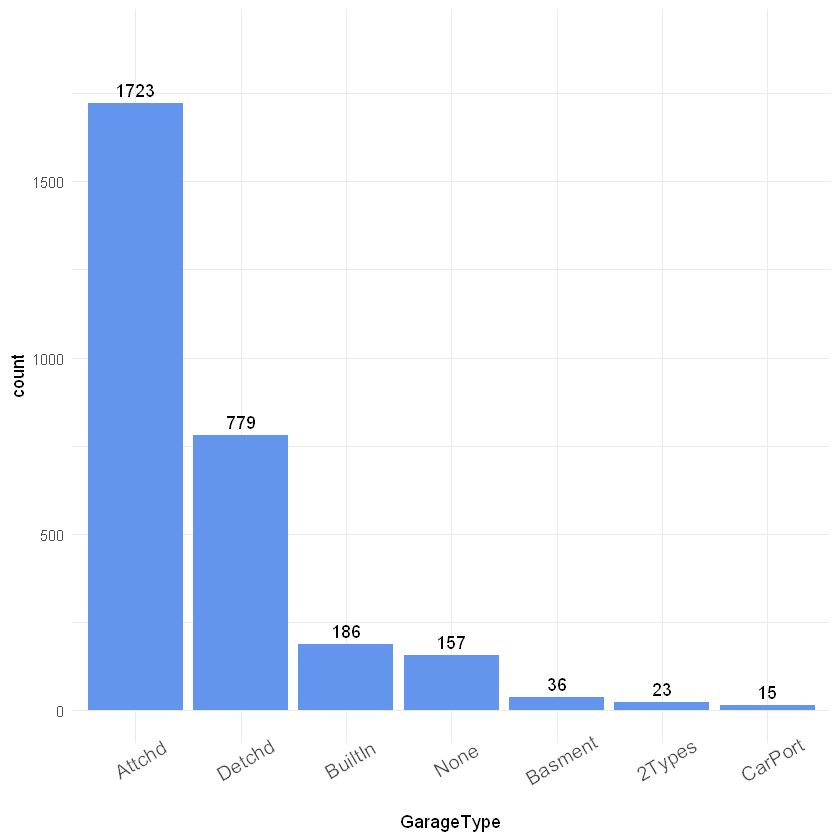

In [162]:
df.numeric['ElectricalSB'] <- (df.combined$Electrical == 'SBrkr') * 1

plot.categoric('GarageType', df.combined)

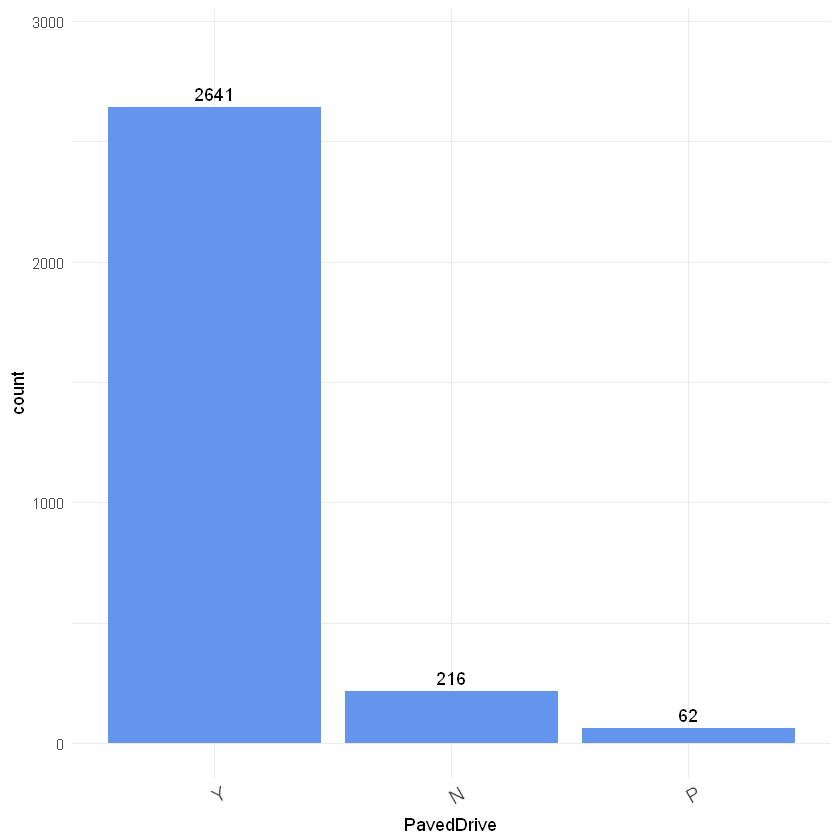

In [163]:
df.numeric['GarageDetchd'] <- (df.combined$GarageType == 'Detchd') * 1

plot.categoric('PavedDrive', df.combined)

In [164]:
df.numeric['HasPavedDrive'] <- (df.combined$PavedDrive == 'Y') * 1

df.numeric['HasWoodDeck'] <- (df.combined$WoodDeckSF > 0) * 1

df.numeric['Has2ndFlr'] <- (df.combined$X2ndFlrSF > 0) * 1

df.numeric['HasMasVnr'] <- (df.combined$MasVnrArea > 0) * 1

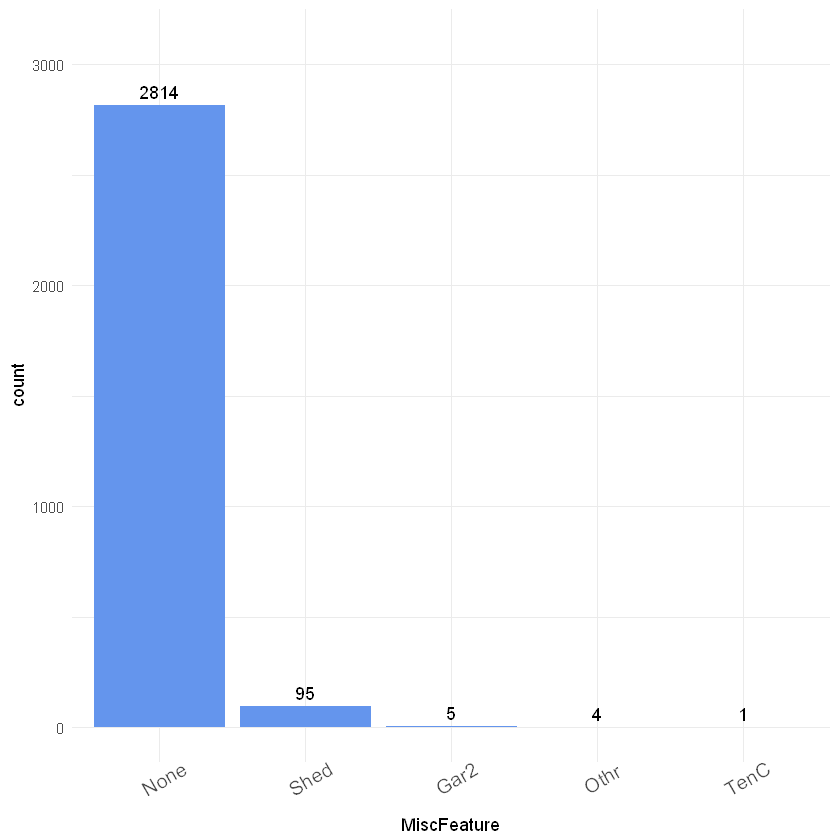

In [165]:
plot.categoric('MiscFeature', df.combined)

In [166]:
df.numeric['HasShed'] <- (df.combined$MiscFeature == 'Shed') * 1

In [167]:
#YearBuilt: Original construction date
#YearRemodAdd: Remodel date
"Many of the houses recorded the same year for YearBuilt and YearRemodAdd. We can create a new column that records that a house was remodelled if the year it was built is different than the remodel year. This"

[1] "Many of the houses recorded the same year for YearBuilt and YearRemodAdd. We can create a new column that records that a house was remodelled if the year it was built is different than the remodel year. This"

In [168]:
df.numeric['Remodeled'] <- (df.combined$YearBuilt != df.combined$YearRemodAdd) * 1

In [169]:
"We can also create a column that seperates which houses have been recently remodelled vs those who are not. Houses that have been remodelled after the year they were sold will fall into this category."

[1] "We can also create a column that seperates which houses have been recently remodelled vs those who are not. Houses that have been remodelled after the year they were sold will fall into this category."

In [170]:
df.numeric['RecentRemodel'] <- (df.combined$YearRemodAdd >= df.combined$YrSold) * 1

In [172]:
"There can be potential value to homes who were sold the same year they were built as this could be an indicator that these houses were hot in the market."

[1] "There can be potential value to homes who were sold the same year they were built as this could be an indicator that these houses were hot in the market."

In [173]:
cols.binary <- c('X2ndFlrSF', 'MasVnrArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'X3SsnPorch', 'ScreenPorch')

for (col in cols.binary){
  df.numeric[str_c('Has',col)] <- (df.combined[,col] != 0) * 1
}

In [174]:
"We know how important the year a house was built and sold but what about what the specific month it was sold? How do houses sold during summer compare to the other seasons?"

[1] "We know how important the year a house was built and sold but what about what the specific month it was sold? How do houses sold during summer compare to the other seasons?"

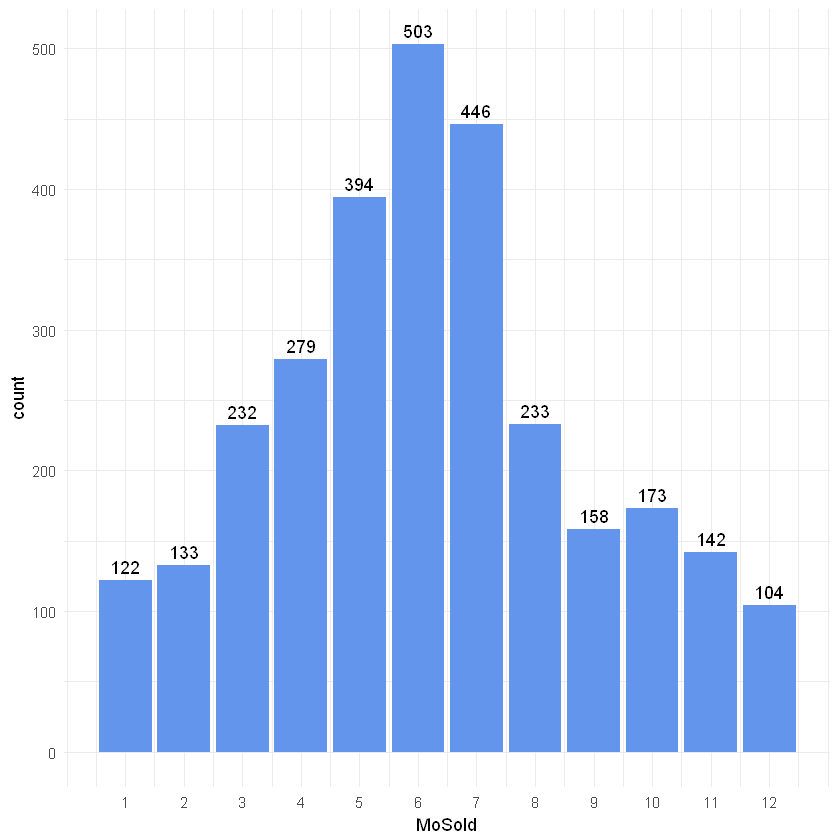

In [175]:
ggplot(df.combined, aes(x=MoSold)) +
  geom_bar(fill = 'cornflowerblue') +
  geom_text(aes(label=..count..), stat='count', vjust = -.5) +
  theme_minimal() +
  scale_x_continuous(breaks = 1:12)

In [176]:
"The largest proportion of houses sold is during the summer months: May, June, July. Let’s add a column that seperates the the summer houses from the rest."

[1] "The largest proportion of houses sold is during the summer months: May, June, July. Lets add a column that seperates the the summer houses from the rest."

In [177]:
df.numeric['HighSeason'] <- (df.combined$MoSold %in% c(5,6,7)) * 1

In [179]:
"Lets check which if we can create a variable with respect to richness of neighborhood"

[1] "Lets check which if we can create a variable with respect to richness of neighborhood"

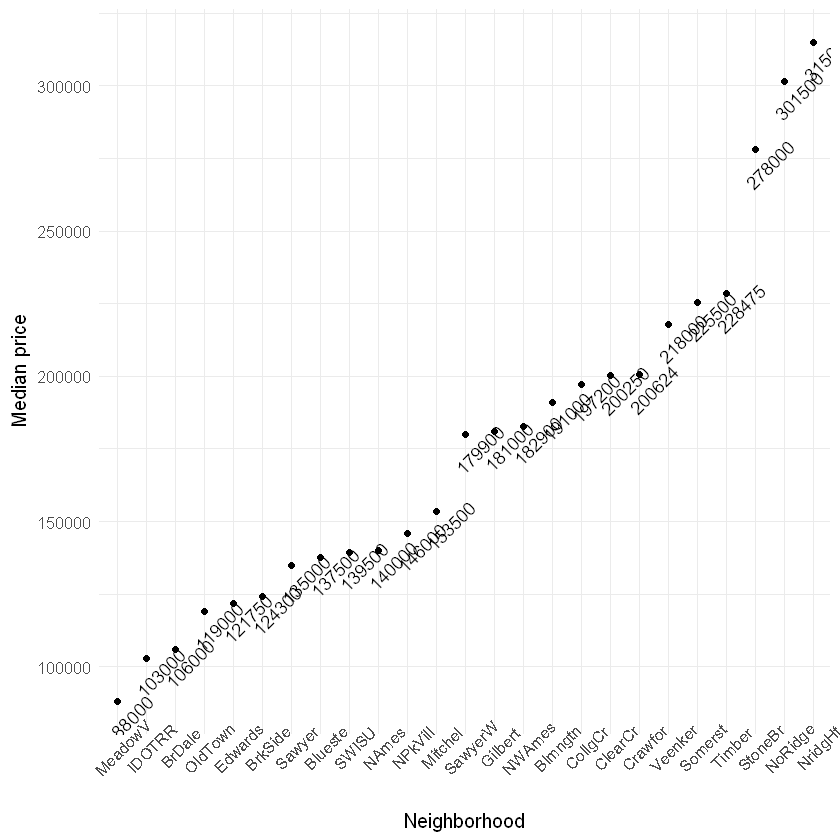

In [180]:
train[,c('Neighborhood','SalePrice')] %>%
  group_by(Neighborhood) %>%
  summarise(median.price = median(SalePrice, na.rm = TRUE)) %>%
  arrange(median.price) %>%
  mutate(nhbr.sorted = factor(Neighborhood, levels=Neighborhood)) %>%
  ggplot(aes(x=nhbr.sorted, y=median.price)) +
  geom_point() +
  geom_text(aes(label = median.price, angle = 45), vjust = 2) +
  theme_minimal() +
  labs(x='Neighborhood', y='Median price') +
  theme(text = element_text(size=12),
        axis.text.x = element_text(angle=45))

In [181]:
"StoneBr, NoRidge, NridgHt have a large gap between them versus the rest of the median prices from any of the other neighborhods. It would be wise of us to check if this is from outliers or if these houses are much pricier as a whole."

[1] "StoneBr, NoRidge, NridgHt have a large gap between them versus the rest of the median prices from any of the other neighborhods. It would be wise of us to check if this is from outliers or if these houses are much pricier as a whole."

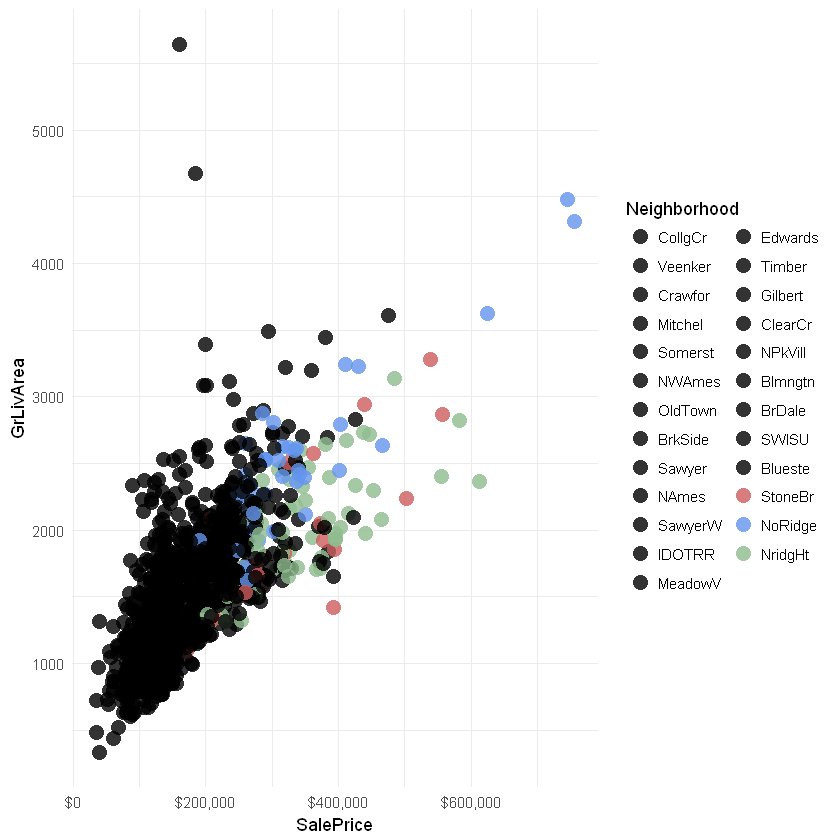

In [182]:
other.nbrh <- unique(df.combined$Neighborhood)[!unique(df.combined$Neighborhood) %in% c('StoneBr', 'NoRidge','NridgHt')]

ggplot(train, aes(x=SalePrice, y=GrLivArea, colour=Neighborhood)) +
  geom_point(shape=16, alpha=.8, size=4) +
  scale_color_manual(limits = c(other.nbrh, 'StoneBr', 'NoRidge', 'NridgHt'), values = c(rep('black', length(other.nbrh)), 'indianred',
                                    'cornflowerblue', 'darkseagreen')) +
  theme_minimal() +
  scale_x_continuous(label=dollar)

In [183]:
"3 houses from StoneBr, NoRidge and NridgHt with house prices over $500,000 which no other Neighborhood is in the same range. What pops out even more in this plot is the 2 houses with an enormous GrLivArea of over 4500 square ft yet very low sale prices. We certianly have an opportunity to explore these outliers in depth, we’ll take a look at this later.

In the mean time lets one-hot encode the more expensive neighborhoods and add that to our dataframe"

[1] "3 houses from StoneBr, NoRidge and NridgHt with house prices over $500,000 which no other Neighborhood is in the same range. What pops out even more in this plot is the 2 houses with an enormous GrLivArea of over 4500 square ft yet very low sale prices. We certianly have an opportunity to explore these outliers in depth, well take a look at this later.\n\nIn the mean time lets one-hot encode the more expensive neighborhoods and add that to our dataframe"

In [185]:
nbrh.rich <- c('Crawfor', 'Somerst, Timber', 'StoneBr', 'NoRidge', 'NridgeHt')
df.numeric['NbrhRich'] <- (df.combined$Neighborhood %in% nbrh.rich) *1

Neighborhood,mean.Quality,mean.Price,n
MeadowV,4.47,98576.47,17
IDOTRR,4.76,100123.78,37
Sawyer,5.03,136793.14,74
BrkSide,5.05,124834.05,58
Edwards,5.08,128219.70,100
NAmes,5.36,145847.08,225
OldTown,5.39,128225.30,113
SWISU,5.44,142591.36,25
Mitchel,5.59,156270.12,49
BrDale,5.69,104493.75,16


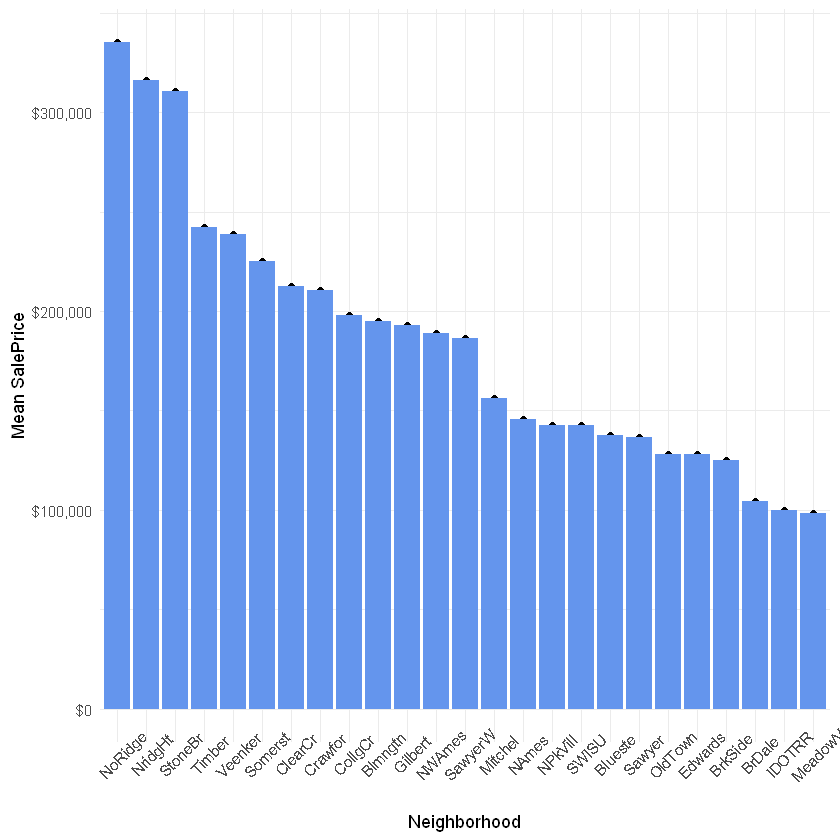

In [186]:
group.prices('Neighborhood')

In [187]:
nbrh.map <- c('MeadowV' = 0, 'IDOTRR' = 1, 'Sawyer' = 1, 'BrDale' = 1, 'OldTown' = 1, 'Edwards' = 1, 
             'BrkSide' = 1, 'Blueste' = 1, 'SWISU' = 2, 'NAmes' = 2, 'NPkVill' = 2, 'Mitchel' = 2,
             'SawyerW' = 2, 'Gilbert' = 2, 'NWAmes' = 2, 'Blmngtn' = 2, 'CollgCr' = 2, 'ClearCr' = 3, 
             'Crawfor' = 3, 'Veenker' = 3, 'Somerst' = 3, 'Timber' = 3, 'StoneBr' = 4, 'NoRidge' = 4, 
             'NridgHt' = 4)

df.numeric['NeighborhoodBin'] <- as.numeric(nbrh.map[df.combined$Neighborhood])

In [188]:
#SaleCondition: Condition of sale

SaleCondition,mean.Quality,mean.Price,n
AdjLand,5.00,104125.0,4
Alloca,5.42,167377.4,12
Abnorml,5.57,146526.6,101
Family,5.80,149600.0,20
Normal,6.01,175202.2,1198
Partial,7.56,272291.8,125


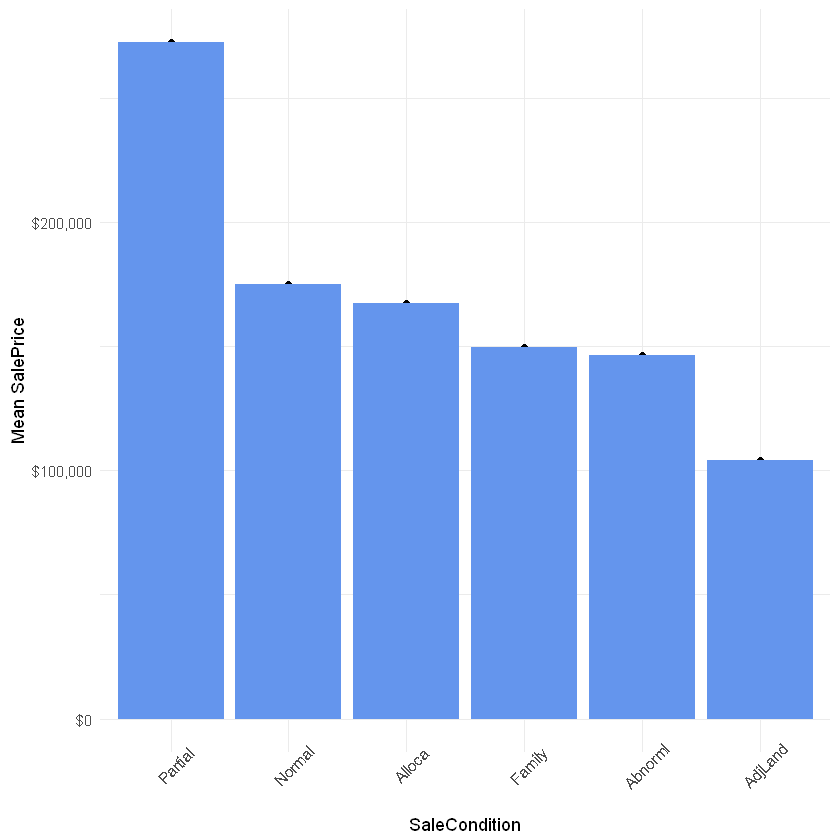

In [189]:
group.prices('SaleCondition')

HeatingQC,mean.Quality,mean.Price,n
Fa,5.00,123919.5,49
Po,5.00,87000.0,1
TA,5.37,142362.9,428
Gd,5.70,156858.9,241
Ex,6.72,214914.4,741


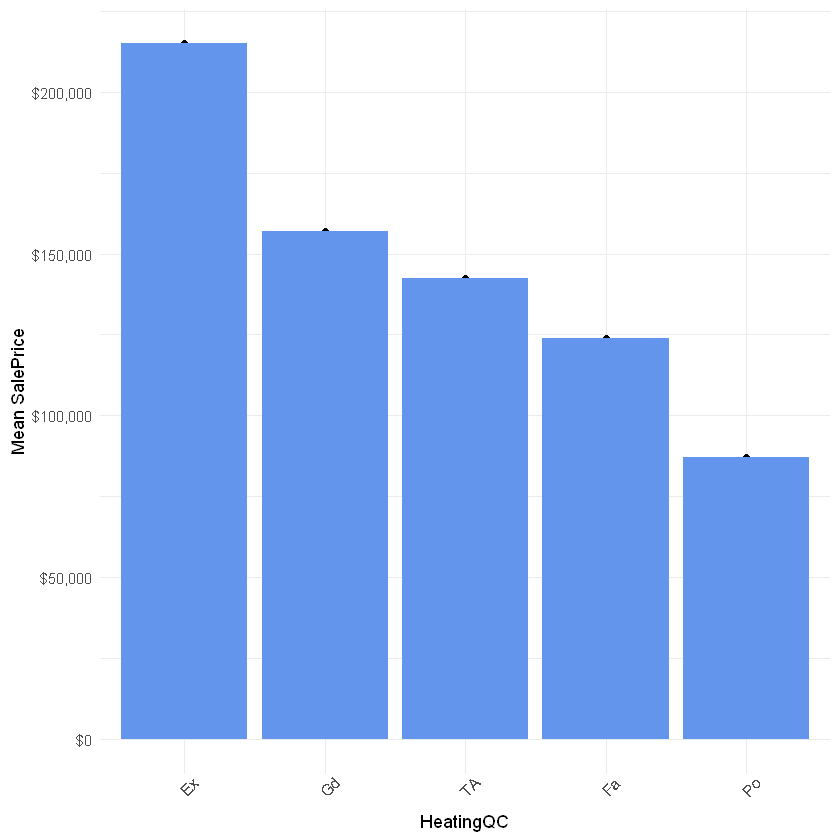

In [190]:
df.numeric['PartialPlan'] <- (df.combined$SaleCondition == 'Partial') * 1

group.prices('HeatingQC')

In [191]:
heating.list <- c('Po' = 0, 'Fa' = 1, 'TA' = 2, 'Gd' = 3, 'Ex' = 4)

df.numeric['HeatingScale'] <- as.numeric(heating.list[df.combined$HeatingQC])

In [192]:
#1stFlrSF: First Floor square feet
#2ndFlrSF: Second floor square feet
#LowQualFinSF: Low quality finished square feet (all floors)

In [193]:
area.cols <- c('LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
             'TotalBsmtSF', 'X1stFlrSF', 'X2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 
             'OpenPorchSF', 'EnclosedPorch', 'X3SsnPorch', 'ScreenPorch', 'LowQualFinSF', 'PoolArea')

df.numeric['TotalArea'] <- as.numeric(rowSums(df.combined[,area.cols]))

In [194]:
df.numeric['AreaInside'] <- as.numeric(df.combined$X1stFlrSF + df.combined$X2ndFlrSF)

In [195]:
df.numeric['Age'] <- as.numeric(2010 - df.combined$YearBuilt)

df.numeric['TimeSinceSold'] <- as.numeric(2010 - df.combined$YrSold)

# how many years since the house was remodelled and sold 
df.numeric['YearSinceRemodel'] <- as.numeric(df.combined$YrSold - df.combined$YearRemodAdd)

In [196]:
# Correlation plot with OverallQual

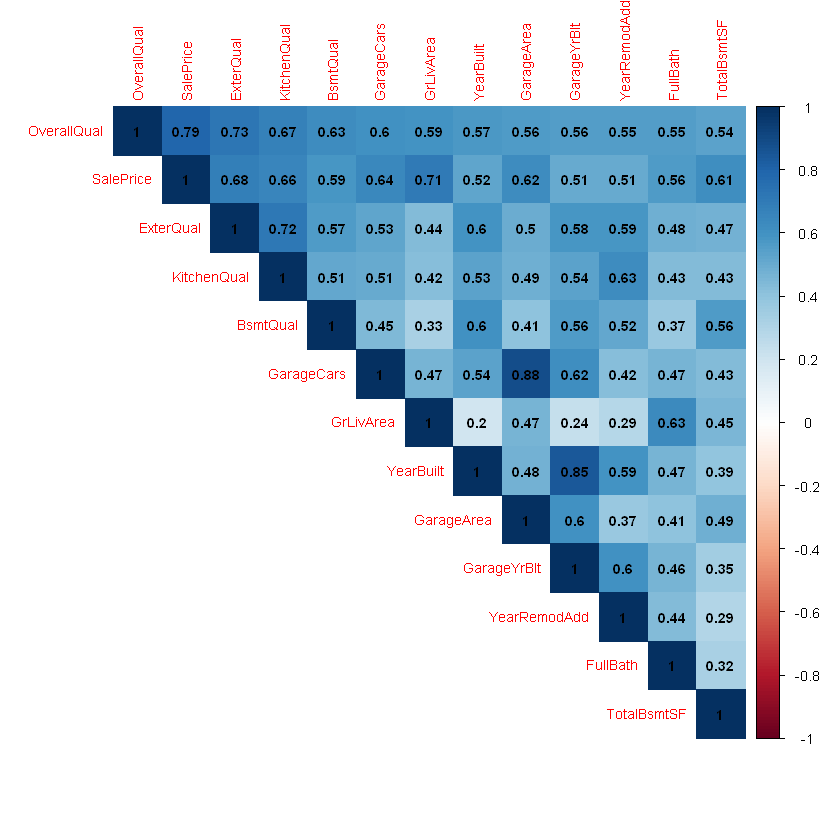

In [197]:
corr.OverallQual <- as.matrix(sort(correlations[,'OverallQual'], decreasing = TRUE))

corr.idx <- names(which(apply(corr.OverallQual, 1, function(x) (x > 0.5 | x < -0.5))))

corrplot(as.matrix(correlations[corr.idx, corr.idx]), type = 'upper',
         method = 'color', addCoef.col = 'black', tl.cex =.7, cl.cex = .7,
         number.cex = .7)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


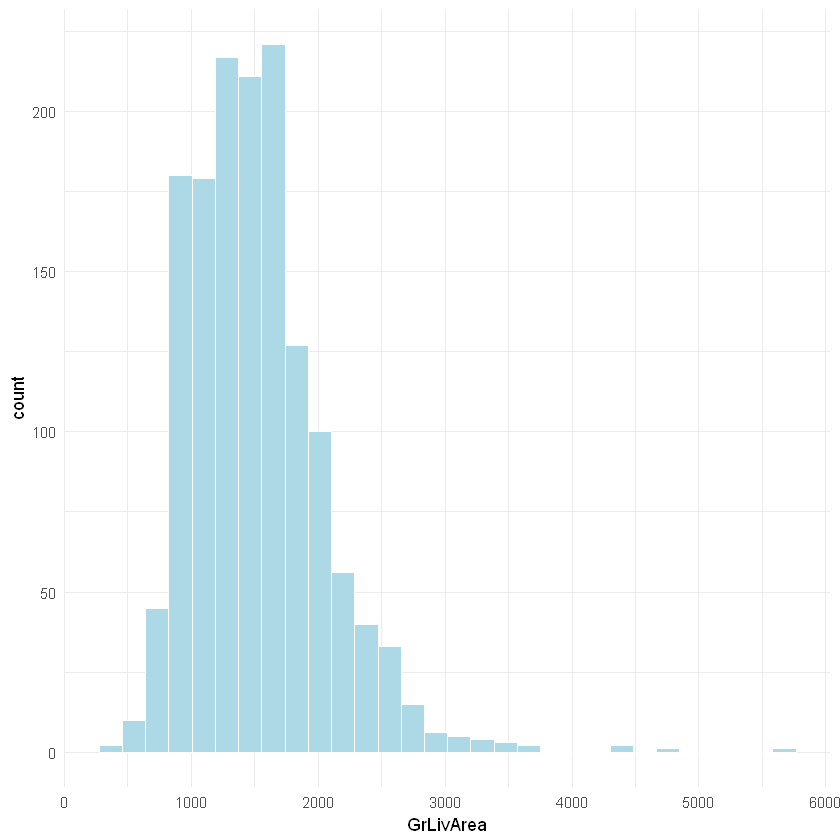

In [198]:
# Outliers
train.test.df <- rbind(dplyr::select(train,-SalePrice), test)
train.test.df$type <- c(rep('train',1460),rep('test',1459))

ggplot(train, aes(x=GrLivArea)) +
  geom_histogram(fill='lightblue',color='white') +
  theme_minimal()

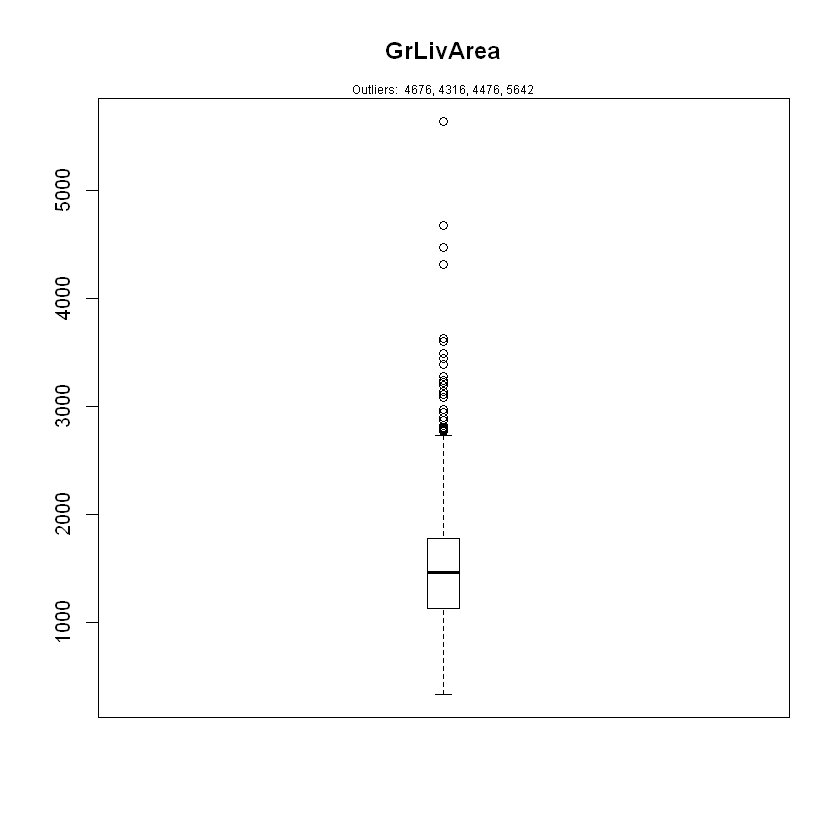

In [199]:
outlier_values <- boxplot.stats(train$GrLivArea)$out  # outlier values.
boxplot(train$GrLivArea, main="GrLivArea", boxwex=0.1)
mtext(paste("Outliers: ", paste(outlier_values[outlier_values>4000], collapse=", ")), cex=0.6)

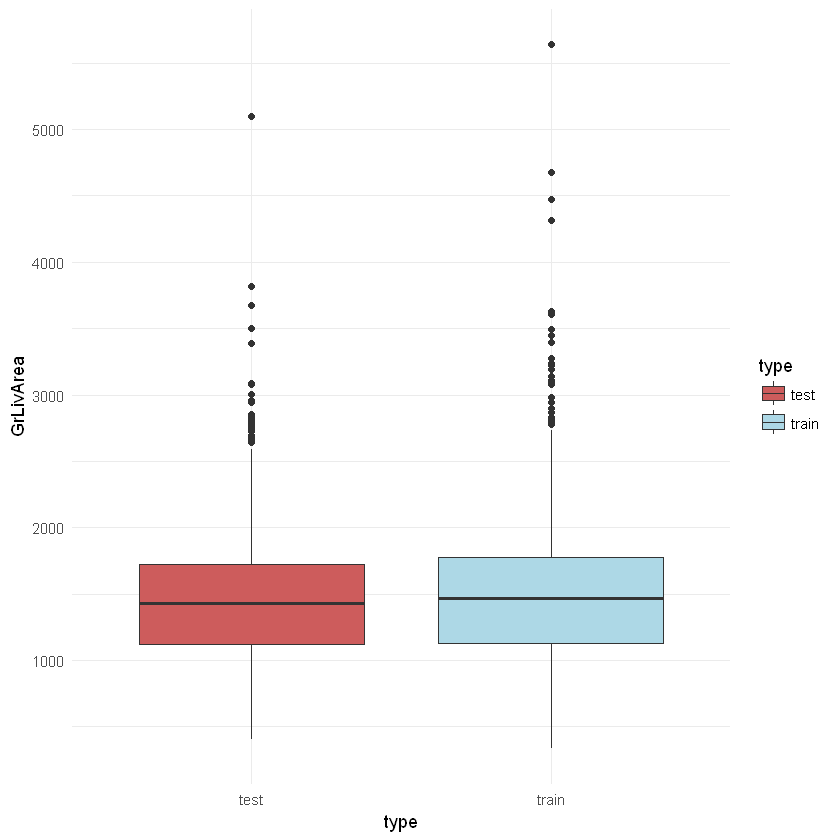

In [200]:
ggplot(train.test.df, aes(x=type, y=GrLivArea, fill=type)) +
  geom_boxplot() +
  theme_minimal() +
  scale_fill_manual(breaks = c("test", "train"), values = c("indianred", "lightblue"))

In [201]:
idx.outliers <- which(train$GrLivArea > 4000)
df.numeric <- df.numeric[!1:nrow(df.numeric) %in% idx.outliers,]
df.combined <- df.combined[!1:nrow(df.combined) %in% idx.outliers,]
dim(df.numeric)

[1] 2915   80

In [202]:
"For the rest of the categoric features we can one-hot encode each value to get as many splits in the data as possible"

[1] "For the rest of the categoric features we can one-hot encode each value to get as many splits in the data as possible"

In [203]:
# one hot encoding for categorical data
# sparse data performs better for trees/xgboost
dummy <- dummyVars(" ~ .",data=df.combined[,cat_features])
df.categoric <- data.frame(predict(dummy,newdata=df.combined[,cat_features]))

In [205]:
"YearBuilt had a correlation coefficient of 0.57 with SalePrice, GarageYrBlt had a coefficiient of 0.56 and YearRemodAdd had scored a 0.55. Knowing how important these features are we want to make as much use with them as possible. The houses in our data start from 1871 and were built up until 2010. We can bin houses into sequences of 20, which will give us 7 different bins for a feature built in a year to fall into. This will allow us to differentiate the different times/era houses, garages and remodeling took place."

[1] "YearBuilt had a correlation coefficient of 0.57 with SalePrice, GarageYrBlt had a coefficiient of 0.56 and YearRemodAdd had scored a 0.55. Knowing how important these features are we want to make as much use with them as possible. The houses in our data start from 1871 and were built up until 2010. We can bin houses into sequences of 20, which will give us 7 different bins for a feature built in a year to fall into. This will allow us to differentiate the different times/era houses, garages and remodeling took place."

In [204]:
# every 20 years create a new bin
# 7 total bins
# min year is 1871, max year is 2010!
year.map = function(col.combined, col.name) {
  for (i in 1:7) {
    year.seq = seq(1871+(i-1)*20, 1871+i*20-1)
    idx = which(df.combined[,col.combined] %in% year.seq)
    df.categoric[idx,col.name] = i
  }
  return(df.categoric)
}

In [206]:
df.categoric['GarageYrBltBin'] = 0
df.categoric <- year.map('GarageYrBlt', 'GarageYrBltBin')
df.categoric['YearBuiltBin'] = 0
df.categoric <- year.map('YearBuilt','YearBuiltBin')
df.categoric['YearRemodAddBin'] = 0
df.categoric <- year.map('YearRemodAdd', 'YearRemodAddBin')

In [208]:
"Now that we 3 new columns that generalize what year a house, garage and remodeling took place we’ll need to one-hot encode these columns so that each bin is turned into a binary column. The new columns are ranged from 1-7, but we don’t know what specific order they follow so it will benefit us more to give each bin its own column."

[1] "Now that we 3 new columns that generalize what year a house, garage and remodeling took place well need to one-hot encode these columns so that each bin is turned into a binary column. The new columns are ranged from 1-7, but we dont know what specific order they follow so it will benefit us more to give each bin its own column."

In [207]:
bin.cols <- c('GarageYrBltBin', 'YearBuiltBin', 'YearRemodAddBin')

for (col in bin.cols) {
  df.categoric <- cbind(df.categoric, model.matrix(~.-1, df.categoric[col]))
}

# lets drop the orginal 'GarageYrBltBin', 'YearBuiltBin', 'YearRemodAddBin' from our dataframe
df.categoric <- df.categoric[,!names(df.categoric) %in% bin.cols]

In [209]:
df <- cbind(df.numeric, df.categoric)

In [212]:
y.true <- train$SalePrice[which(!1:1460 %in% idx.outliers)]
y_train <- log(y.true+1)
x_train <- df[1:1456,]

x_test <- df[1457:nrow(df),]

dtrain <- xgb.DMatrix(as.matrix(x_train), label = y_train)
dtest <- xgb.DMatrix(as.matrix(x_test))

In [224]:
# Training model
# XgBoost
xgb_params <- list(
  booster = 'gbtree',
  objective = 'reg:linear',
  colsample_bytree=1,
  eta=0.01,
  max_depth=4,
  min_child_weight=3,
  alpha=0.3,
  lambda=0.4,
  gamma=0.01, # less overfit
  subsample=0.6,
  seed=5,
  silent=TRUE)
xgb.fit <- xgb.train(xgb_params,dtrain, nrounds = 50000)

In [225]:
rmse_eval <- function(y.true, y.pred) {
  mse_eval <- sum((y.true - exp(y.pred)-1)^2) / length(y.true)
  return(sqrt(mse_eval))
}

y_pred.xgb <- predict(xgb.fit, dtrain)
rmse_eval(y.true, y_pred.xgb)

[1] 7472.43

In [219]:
# ridge, lasso, elasticnet

glm.cv.ridge <- cv.glmnet(as.matrix(x_train), y_train, alpha = 0)
glm.cv.lasso <- cv.glmnet(as.matrix(x_train), y_train, alpha = 1)
glm.cv.net <- cv.glmnet(data.matrix(x_train), y_train, alpha = 0.001)

# use the lamdba that minimizes the error
penalty.ridge <- glm.cv.ridge$lambda.min
penalty.lasso <- glm.cv.lasso$lambda.min
penalty.net <- glm.cv.net$lambda.min

In [220]:
glm.ridge <- glmnet(x = as.matrix(x_train), y = y_train, alpha = 0, lambda = penalty.ridge )
glm.lasso <- glmnet(x = as.matrix(x_train), y = y_train, alpha = 1, lambda = penalty.lasso)
glm.net <- glmnet(x = as.matrix(x_train), y = y_train, alpha = 0.001, lambda = penalty.net)

y_pred.ridge <- as.numeric(predict(glm.ridge, as.matrix(x_train)))
y_pred.lasso <- as.numeric(predict(glm.lasso, as.matrix(x_train)))
y_pred.net <- as.numeric(predict(glm.net, as.matrix(x_train)))

In [221]:
rmse_eval(y.true, y_pred.ridge)
rmse_eval(y.true, y_pred.lasso)
rmse_eval(y.true, y_pred.net)

[1] 17289.25

[1] 18192

[1] 17321.09

In [215]:
"Here we have the RMSE for elastic-net, lasso and ridge are all very similar yet not as low as the RMSE we got from XGBoost, however, ridge, lasso, and elastic-nets ability to extrapolate saleprices beyond the range we were given in the training set will be crucial for predicting more accurately towards unseen data (future houses). If we combine all 4 of these predictions on our test data by taking a weighted average of all of our predictions, we can get what we hope to be an accurate submission. Note: our predictions are in logarithmic form since we made a transformation due to the skewness in the Saleprices so we will need to tranform our predictions back into their original form by taking f(x)=ex−1."

[1] "Here we have the RMSE for elastic-net, lasso and ridge are all very similar yet not as low as the RMSE we got from XGBoost, however, ridge, lasso, and elastic-nets ability to extrapolate saleprices beyond the range we were given in the training set will be crucial for predicting more accurately towards unseen data (future houses). If we combine all 4 of these predictions on our test data by averaging all of our predictions we can get what we hope to be an accurate submission. Note: our predictions are in logarithmic form since we made a transformation due to the skewness in the Saleprices so we will need to tranform our predictions back into their original form by taking f(x)=ex-1."

In [271]:
y_pred.ridge <- as.double(predict(glm.ridge, as.matrix(x_test)))
y_pred.lasso <- as.double(predict(glm.lasso, as.matrix(x_test)))
y_pred.net <- as.double(predict(glm.net, as.matrix(x_test)))

y_pred.ridge <- as.double(exp(y_pred.ridge) - 1)
y_pred.lasso <- as.double(exp(y_pred.lasso) - 1)
y_pred.net <- as.double(exp(y_pred.net) - 1)

y_pred.xgb <- as.double(predict(xgb.fit, dtest))
y_pred.xgb <- as.double(exp(y_pred.xgb) - 1)

# take the average of our predictions for our ensemble
y_pred <- (3*y_pred.xgb + y_pred.ridge + y_pred.lasso + y_pred.net)/6.0
head(y_pred)

[1] 123630.8 160553.2 181168.7 196089.5 188410.7 168689.4

In [270]:
ens1 <- as.data.frame(test$Id)
names(ens1) <- 'Id'
ens1$SalePrice <- y_pred
write.csv(ens1, "ens1.csv", row.names = FALSE)

In [272]:
"My ensemble got an RMSE score of 0.12142 on the Public Leaderboard"

[1] "My ensemble got an RMSE score of 0.12142 on the Public Leaderboard"